In [110]:
import os, random, numpy as np
import pandas as pd
from pathlib import Path
import shutil
from questionnaire_functions import (export_questionnaire,build_timepoint_presence_matrix,analyze_questionnaire)
from pca_functions import (find_optimal_pca_dimensions,plot_pca_weights_two_cols_split,plot_pca_weights_separate_and_table)
from clustring_functions import(pca_kmeans_minimal_outputs,run_kmeans_clustering,invert_binary_columns,gap_statistic)
from vizualizations_functions import (plot_grouped_bars,plot_multi_dataset_scatters_colored,plot_one_period_with_labels,get_labels_from_file,plot_one_period_with_labels_and_ttest,
plot_subject_trajectories,stats_by_group,safe)
from preprocessing_functions import (load_one,transition_for_pair)
from functools import reduce
import textwrap
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_rel



In [111]:
SEED = 17
os.environ["PYTHONHASHSEED"] = str(SEED)

# לכבות רנדומליות בספריות BLAS/OMP
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

random.seed(SEED)
np.random.seed(SEED)

print("Seed fixed:", SEED)

Seed fixed: 17


# preparing the data

In [112]:


file_path = r'data\original_Q_data\Study_Questionnaire_Responses_October.xlsx'
columns_to_select = ["Subject_Code", "b_questionnaire_completion", "after_questionnaire_completion", "t1_MAAS_date", "t2_PHQ_date", "t3_MAAS_date"]

df = pd.read_excel(file_path)
columns = df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)

selected_df = df.loc[:, columns_to_select]

print("DataFrame with selected columns")
print(f"lines: {selected_df .shape[0]}, columns: {selected_df .shape[1]}")


print("\nהצגת ה-DataFrame החדש (5 השורות הראשונות):")
print(selected_df.head())


the columns in the dataframe:
study_id
Subject_Code
diamond_interview_date
b_diamond_anxiety_phobias_past
b_diamond_Anxiety_phobias_present
b_diamond_ocd_past
b_diamond_ocd_present
b_diamond_adhd_past
b_diamond_adhd_present
b_diamond_depression_past
b_diamond_depression_present
b_diamond_adjustment_past
b_diamond_adjustment_present
b_diamond_ptsd_past
b_diamond_ptsd_present
b_diamond_eating_disorder_past
b_diamond_eating_disorder_present
b_diamond_PMS_past
b_diamond_PMS_present
b_diamond_other_past
b_diamond_other_present
b_diamond_past
b_diamond_present
Dropped_Out_of_Study
Became_Pregnant
Gave_Birth
Dominant_hand
Completed_First_fMRI
Completed_Second_fMRI
Completed_Third_fMRI
b_questionnaire_completion
after_questionnaire_completion
first_fmri_scan_date
second_fmri_scan_date
third_fmri_scan_date
b_questionnaire_and_fmri_days_difference
pregnancy_start_date
b_questionnaire_and_pregnancy_days_difference
b_fmri_and_pregnancy_days_difference
newborn_birth_date
b_questionnaire_and_deliver

In [113]:
# see the columns in the dataframe
columns = selected_df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)
phq_columns = ['b_PHQ_1','b_PHQ_2','b_PHQ_3','b_PHQ_4','b_PHQ_5','b_PHQ_6','b_PHQ_7','b_PHQ_8','b_PHQ_9',
't1_PHQ_1','t1_PHQ_2','t1_PHQ_3','t1_PHQ_4','t1_PHQ_5','t1_PHQ_6','t1_PHQ_7','t1_PHQ_8','t1_PHQ_9','t2_PHQ_1','t2_PHQ_2','t2_PHQ_3','t2_PHQ_4','t2_PHQ_5','t2_PHQ_6','t2_PHQ_7','t2_PHQ_8','t2_PHQ_9', 't3_PHQ_1','t3_PHQ_2','t3_PHQ_3','t3_PHQ_4','t3_PHQ_5','t3_PHQ_6','t3_PHQ_7','t3_PHQ_8','t3_PHQ_9','after_PHQ_1','after_PHQ_2','after_PHQ_3','after_PHQ_4','after_PHQ_5','after_PHQ_6','after_PHQ_7','after_PHQ_8','after_PHQ_9']
gad_columns = ['b_GAD7_1','b_GAD7_2','b_GAD7_3','b_GAD7_4','b_GAD7_5','b_GAD7_6','b_GAD7_7',
't1_GAD7_1','t1_GAD7_2','t1_GAD7_3','t1_GAD7_4','t1_GAD7_5','t1_GAD7_6','t1_GAD7_7',
't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6',
't2_GAD7_7', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7',
'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'after_GAD7_5', 'after_GAD7_6', 'after_GAD7_7']




the columns in the dataframe:
Subject_Code
b_questionnaire_completion
after_questionnaire_completion
t1_MAAS_date
t2_PHQ_date
t3_MAAS_date


In [114]:
df_cleaned = df[['Subject_Code','Dropped_Out_of_Study']+phq_columns+gad_columns]
print(df_cleaned.columns.tolist())

# Remove the subjects who were dropped out of the study
df_filtered = df_cleaned[df_cleaned['Dropped_Out_of_Study'] != 1]

# calculating the number of nan in each column
counts = df_filtered.notna().sum()

# Calculating the percentage of respondents who answered the specific questionnaire out of all respondents
total = len(df_filtered)
percentages = (counts / total * 100)

# creating a new table of number of students and the precentages of the subjects
summary_df = pd.DataFrame([counts, percentages], index=['number of subject', '% of subjects'])


# שמירת הטבלה כקובץ Excel
summary_df.to_excel("only_Q_outputs/combined/summary_table.xlsx")


['Subject_Code', 'Dropped_Out_of_Study', 'b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 't1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 'after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7', 'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_

In [115]:
# הרצה עבור כל סט
export_questionnaire(df_cleaned, 'b', 'only_Q_outputs/5_timepoints/b_questionnaire')
export_questionnaire(df_cleaned, 't1', 'only_Q_outputs/5_timepoints/t1_questionnaire')
export_questionnaire(df_cleaned, 't2', 'only_Q_outputs/5_timepoints/t2_questionnaire')
export_questionnaire(df_cleaned, 't3', 'only_Q_outputs/5_timepoints/t3_questionnaire')
export_questionnaire(df_cleaned, 'after', 'only_Q_outputs/5_timepoints/after_questionnaire')


✅ נוצר הקובץ: only_Q_outputs/5_timepoints/b_questionnaire.csv
📌 מספר נבדקות בקובץ: 167
📋 עמודות שנכללו:
b_PHQ_1, b_PHQ_2, b_PHQ_3, b_PHQ_4, b_PHQ_5, b_PHQ_6, b_PHQ_7, b_PHQ_8, b_PHQ_9, b_GAD7_1, b_GAD7_2, b_GAD7_3, b_GAD7_4, b_GAD7_5, b_GAD7_6, b_GAD7_7

✅ נוצר הקובץ: only_Q_outputs/5_timepoints/t1_questionnaire.csv
📌 מספר נבדקות בקובץ: 149
📋 עמודות שנכללו:
t1_PHQ_1, t1_PHQ_2, t1_PHQ_3, t1_PHQ_4, t1_PHQ_5, t1_PHQ_6, t1_PHQ_7, t1_PHQ_8, t1_PHQ_9, t1_GAD7_1, t1_GAD7_2, t1_GAD7_3, t1_GAD7_4, t1_GAD7_5, t1_GAD7_6, t1_GAD7_7

✅ נוצר הקובץ: only_Q_outputs/5_timepoints/t2_questionnaire.csv
📌 מספר נבדקות בקובץ: 140
📋 עמודות שנכללו:
t2_PHQ_1, t2_PHQ_2, t2_PHQ_3, t2_PHQ_4, t2_PHQ_5, t2_PHQ_6, t2_PHQ_7, t2_PHQ_8, t2_PHQ_9, t2_GAD7_1, t2_GAD7_2, t2_GAD7_3, t2_GAD7_4, t2_GAD7_5, t2_GAD7_6, t2_GAD7_7

✅ נוצר הקובץ: only_Q_outputs/5_timepoints/t3_questionnaire.csv
📌 מספר נבדקות בקובץ: 131
📋 עמודות שנכללו:
t3_PHQ_1, t3_PHQ_2, t3_PHQ_3, t3_PHQ_4, t3_PHQ_5, t3_PHQ_6, t3_PHQ_7, t3_PHQ_8, t3_PHQ_9, t3_GA

In [116]:
q_before = r'data\original_Q_data\5_timepoints\b_questionnaire.csv'
q_t1  = r'data\original_Q_data\5_timepoints\t1_questionnaire.csv'
q_t2 = r'data\original_Q_data\5_timepoints\t2_questionnaire.csv'
q_t3 = r'data\original_Q_data\5_timepoints\t3_questionnaire.csv'
q_after = r'data\original_Q_data\5_timepoints\after_questionnaire.csv'

analyze_questionnaire('b',q_before)
analyze_questionnaire( 't1', q_t1)
analyze_questionnaire( 't2', q_t2)
analyze_questionnaire('t3', q_t3)
analyze_questionnaire( 'after', q_after)



📘 קובץ: data\original_Q_data\5_timepoints\b_questionnaire.csv
👥 נבדקות פעילות: 167
   🔸 PHQ: ממוצע השתתפות 100.00% (9 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data\original_Q_data\5_timepoints\t1_questionnaire.csv
👥 נבדקות פעילות: 149
   🔸 PHQ: ממוצע השתתפות 100.00% (9 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data\original_Q_data\5_timepoints\t2_questionnaire.csv
👥 נבדקות פעילות: 140
   🔸 PHQ: ממוצע השתתפות 100.00% (9 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data\original_Q_data\5_timepoints\t3_questionnaire.csv
👥 נבדקות פעילות: 131
   🔸 PHQ: ממוצע השתתפות 100.00% (9 שאלות)
   🔸 GAD7: ממוצע השתתפות 99.56% (7 שאלות)

📘 קובץ: data\original_Q_data\5_timepoints\after_questionnaire.csv
👥 נבדקות פעילות: 142
   🔸 PHQ: ממוצע השתתפות 99.92% (9 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)


In [117]:
timepoint_files = {
    'b': r'data\original_Q_data\5_timepoints\b_questionnaire.csv',
    't1': r'data\original_Q_data\5_timepoints\t1_questionnaire.csv',
    't2': r'data\original_Q_data\5_timepoints\t2_questionnaire.csv',
    't3': r'data\original_Q_data\5_timepoints\t3_questionnaire.csv',
    'after': r'data\original_Q_data\5_timepoints\after_questionnaire.csv'
}

build_timepoint_presence_matrix(
    timepoint_files,
    r'data\original_Q_data\5_timepoints\subject_timepoint_presence.csv'
)


✅ Presence matrix created: data\original_Q_data\5_timepoints\subject_timepoint_presence.csv
👥 Total subjects: 171


In [118]:
presence_df = pd.read_csv(
    'only_Q_outputs/5_timepoints/subject_timepoint_presence.csv'
)

# keep only subjects that appear in ALL timepoints
timepoint_cols = ['b', 't1', 't2', 't3', 'after']

valid_subjects = presence_df.loc[
    presence_df[timepoint_cols].eq(1).all(axis=1),
    'Subject_Code'
]


In [119]:
import os

filtered_dir = 'only_Q_outputs/5_timepoints/complete_subjects'
os.makedirs(filtered_dir, exist_ok=True)

def filter_timepoint_file_to_new_folder(input_csv, output_dir, valid_subjects):
    df = pd.read_csv(input_csv)

    if 'Subject_Code' not in df.columns:
        raise ValueError(f"Subject_Code missing in {input_csv}")

    df_filtered = df[df['Subject_Code'].isin(valid_subjects)].copy()

    output_path = os.path.join(output_dir, os.path.basename(input_csv))

    print(f"📄 {os.path.basename(input_csv)}")
    print(f"   👥 before: {df['Subject_Code'].nunique()}")
    print(f"   ✅ after : {df_filtered['Subject_Code'].nunique()}")

    df_filtered.to_csv(output_path, index=False)

timepoint_files = {
    'b': 'only_Q_outputs/5_timepoints/b_questionnaire.csv',
    't1': 'only_Q_outputs/5_timepoints/t1_questionnaire.csv',
    't2': 'only_Q_outputs/5_timepoints/t2_questionnaire.csv',
    't3': 'only_Q_outputs/5_timepoints/t3_questionnaire.csv',
    'after': 'only_Q_outputs/5_timepoints/after_questionnaire.csv'
}

for path in timepoint_files.values():
    filter_timepoint_file_to_new_folder(
        input_csv=path,
        output_dir=filtered_dir,
        valid_subjects=valid_subjects
    )


📄 b_questionnaire.csv
   👥 before: 167
   ✅ after : 109
📄 t1_questionnaire.csv
   👥 before: 149
   ✅ after : 109
📄 t2_questionnaire.csv
   👥 before: 140
   ✅ after : 109
📄 t3_questionnaire.csv
   👥 before: 131
   ✅ after : 109
📄 after_questionnaire.csv
   👥 before: 142
   ✅ after : 109


In [120]:
q_before = r'data\original_Q_data\5_timepoints_complete\b_questionnaire.csv'
q_t1  = r'data\original_Q_data\5_timepoints_complete\t1_questionnaire.csv'
q_t2 = r'data\original_Q_data\5_timepoints_complete\t2_questionnaire.csv'
q_t3 = r'data\original_Q_data\5_timepoints_complete\t3_questionnaire.csv'
q_after = r'data\original_Q_data\5_timepoints_complete\after_questionnaire.csv'

In [121]:
df_before = pd.read_csv(q_before)
prefix = "b"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_before.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_before.columns]
df_before['timepoint'] = prefix
print(df_before.columns)

df_t1 = pd.read_csv(q_t1)
prefix = "t1"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_t1['timepoint'] = prefix
df_t1.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_t1.columns]
print(df_t1.columns)

df_t2 = pd.read_csv(q_t2)
prefix = "t2"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_t2['timepoint'] = prefix
df_t2.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_t2.columns]
print(df_t2.columns)

df_t3 = pd.read_csv(q_t3)
prefix = "t3"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_t3['timepoint'] = prefix
df_t3.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_t3.columns]
print(df_t3.columns)

df_after = pd.read_csv(q_after)
prefix = "after"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_after['timepoint'] = prefix
df_after.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_after.columns]
print(df_after.columns)



Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'GAD7_1', 'GAD7_2',
       'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7', 'timepoint'],
      dtype='object')
Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'GAD7_1', 'GAD7_2',
       'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7', 'timepoint'],
      dtype='object')
Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'GAD7_1', 'GAD7_2',
       'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7', 'timepoint'],
      dtype='object')
Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'GAD7_1', 'GAD7_2',
       'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7', 'timepoint'],
      dtype='object')
Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'P

In [122]:



# 1. יצירת רשימה של כל הדאטה-פריימים
list_of_dfs = [df_before, df_t1, df_t2,df_t3,df_after]

# 2. שימוש ב-pd.concat לשרשור הרשימה
# אנחנו משתמשים ב-ignore_index=True כדי שהאינדקס של התוצאה יהיה רציף (...0, 1, 2, 3)
# אם לא נשתמש בזה, נקבל אינדקסים שחוזרים על עצמם (למשל ...0, 1, 0, 1, 0, 1)
df_combined = pd.concat(list_of_dfs, ignore_index=True)

print("\n--- DataFrame מאוחד ---")
df_combined = df_combined.drop(columns = 'Unnamed: 0')
print(df_combined)
df_combined.to_csv(r'data\original_Q_data\combined\combined_only_complete_subjects.csv')


--- DataFrame מאוחד ---


    Subject_Code  PHQ_1  PHQ_2  PHQ_3  PHQ_4  PHQ_5  PHQ_6  PHQ_7  PHQ_8  \
0          NT005    0.0    2.0    0.0    1.0    1.0    1.0    1.0    0.0   
1          NT002    1.0    1.0    1.0    3.0    2.0    0.0    1.0    0.0   
2          NT001    0.0    0.0    1.0    1.0    0.0    0.0    0.0    0.0   
3          NT007    3.0    2.0    2.0    2.0    3.0    2.0    3.0    0.0   
4          CT004    0.0    0.0    1.0    1.0    0.0    1.0    1.0    0.0   
..           ...    ...    ...    ...    ...    ...    ...    ...    ...   
540        CT062    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
541        CT061    1.0    1.0    1.0    1.0    0.0    0.0    2.0    0.0   
542        NT129    2.0    3.0    3.0    2.0    3.0    2.0    2.0    1.0   
543        NT131    0.0    0.0    1.0    2.0    1.0    0.0    0.0    0.0   
544        NT136    1.0    1.0    0.0    1.0    1.0    2.0    2.0    0.0   

     PHQ_9  GAD7_1  GAD7_2  GAD7_3  GAD7_4  GAD7_5  GAD7_6  GAD7_7 timepoint  
0      0

# pca and k means for the combined data 

## find optimal number of clusters 


--- DataFrame מאוחד ---
    Subject_Code  PHQ_1  PHQ_2  PHQ_3  PHQ_4  PHQ_5  PHQ_6  PHQ_7  PHQ_8  \
0          NT005    0.0    2.0    0.0    1.0    1.0    1.0    1.0    0.0   
1          NT002    1.0    1.0    1.0    3.0    2.0    0.0    1.0    0.0   
2          NT001    0.0    0.0    1.0    1.0    0.0    0.0    0.0    0.0   
3          NT007    3.0    2.0    2.0    2.0    3.0    2.0    3.0    0.0   
4          CT004    0.0    0.0    1.0    1.0    0.0    1.0    1.0    0.0   
..           ...    ...    ...    ...    ...    ...    ...    ...    ...   
540        CT062    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
541        CT061    1.0    1.0    1.0    1.0    0.0    0.0    2.0    0.0   
542        NT129    2.0    3.0    3.0    2.0    3.0    2.0    2.0    1.0   
543        NT131    0.0    0.0    1.0    2.0    1.0    0.0    0.0    0.0   
544        NT136    1.0    1.0    0.0    1.0    1.0    2.0    2.0    0.0   

     PHQ_9  GAD7_1  GAD7_2  GAD7_3  GAD7_4  GAD7_5  GAD7_6  GA

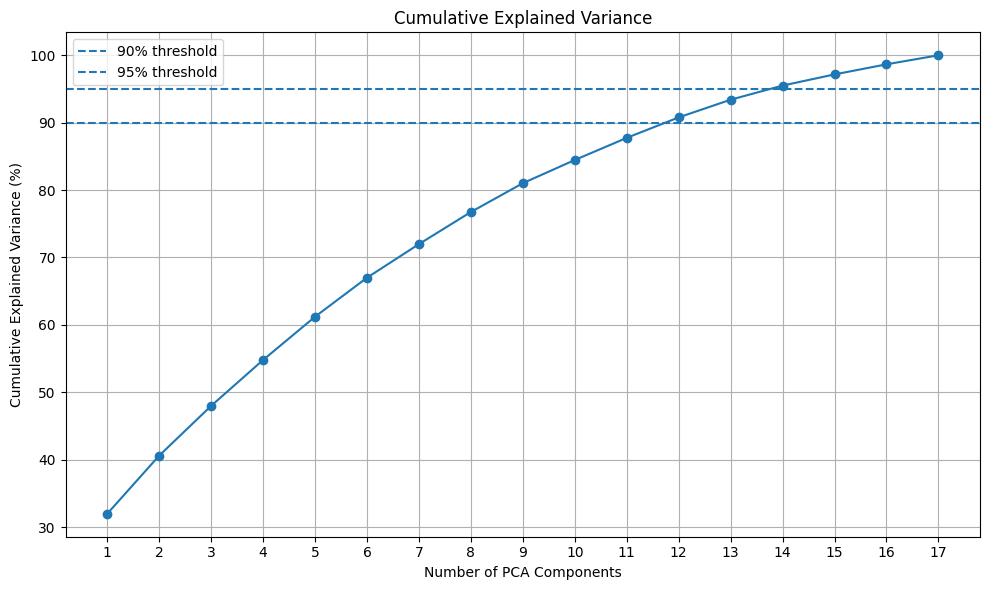

✅ 90% variance: 12 components
✅ 95% variance: 14 components
✅ 100% variance: 17 components
🖼️ Saved figure: data/only_Q_outputs/combined/ses1_figures\b_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 12


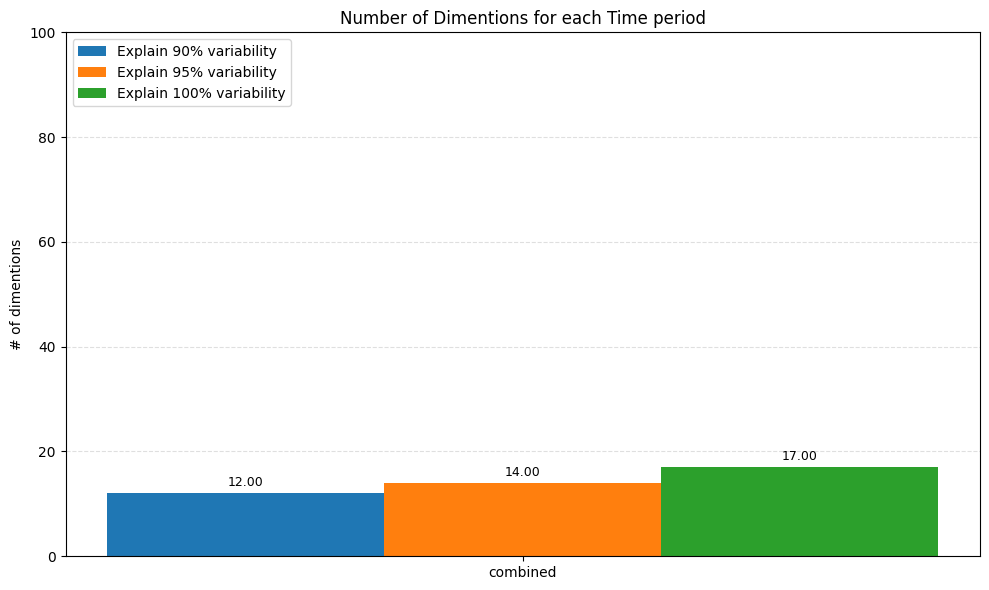

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Number of Dimentions for each Time period'}, ylabel='# of dimentions'>)

In [123]:
print("\n--- DataFrame מאוחד ---") 
print(df_combined)
df_combined.to_csv(r'data\original_Q_data\combined\combined_only_complete_subjects.csv')
n_dims_comb_90, n_dims_comb_95, n_dims_comb_100 = find_optimal_pca_dimensions(q_before,save_dir="data/only_Q_outputs/combined/ses1_figures") 
print(f"\nRecommended number of dimensions for 90%: {n_dims_comb_90}")
groups = ["combined"] 
s1 = [n_dims_comb_90] 
s2 = [n_dims_comb_95]
s3 = [n_dims_comb_100]# values for column 1 in each s2 = [n_dims_comb_95] # values for column 2 s3 = [n_dims_comb_100] 
plot_grouped_bars(groups, s1, s2, s3, s1_label="Explain 90% variability",s2_label="Explain 95% variability",s3_label="Explain 100% variability", title="Number of Dimentions for each Time period",ylabel="# of dimentions") 


## search for optimal clusters number


Prefix is empty, selecting 'PHQ_' and 'GAD7_' columns explicitly.
[[-0.71159995  2.07394404 -1.1464     ... -0.32756668  0.44387795
  -0.64990945]
 [ 0.66854942  0.59449443 -0.13867742 ... -0.32756668  0.44387795
   0.83832858]
 [-0.71159995 -0.88495518 -0.13867742 ... -0.32756668  0.44387795
  -0.64990945]
 ...
 [ 2.04869879  3.55339365  1.87676775 ... -0.32756668  0.44387795
   2.32656661]
 [-0.71159995 -0.88495518 -0.13867742 ... -0.32756668  0.44387795
   2.32656661]
 [ 0.66854942  0.59449443 -1.1464     ... -0.32756668 -0.8428959
   0.83832858]]

✅ נתוני PCA נשמרו בהצלחה ב: only_Q_outputs\combined\combined_pca_components.csv


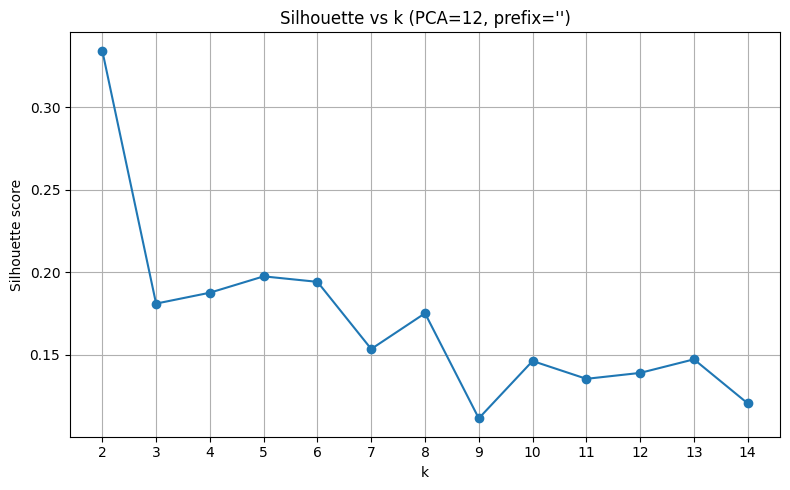


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
    subject_id  cluster  silhouette_sample
0        NT005        0           0.337821
1        NT002        0           0.253999
2        NT001        0           0.552098
3        NT007        1           0.185653
4        CT004        0           0.489105
..         ...      ...                ...
540      CT062        0           0.609907
541      CT061        0           0.137389
542      NT129        1           0.231289
543      NT131        0           0.362788
544      NT136        1           0.019885

[545 rows x 3 columns]


In [124]:
# השתמש בפונקציה המתוקנת שהגדרנו למעלה
res_comb = pca_kmeans_minimal_outputs(
    df_combined,
    prefix="",  # עכשיו הפונקציה יודעת לטפל בזה
    n_components=n_dims_comb_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="only_Q_outputs/combined",
    subject_id_col='Subject_Code', # <--- הוסף את השורה הזו
    save_pca_csv = r'only_Q_outputs\combined\combined_pca_components.csv'
)

In [125]:
sil_scores_comb = res_comb["sil_scores"]
print("k* =", res_comb["best_k"])


ks = list(range(2, 15))  # same k_range you used in the runs

sil_comb = res_comb["sil_scores"].iloc[:, 0].values


best_k_comb_sil = res_comb["best_k"]

k* = 2


## mark time periods on the pca sctater plot

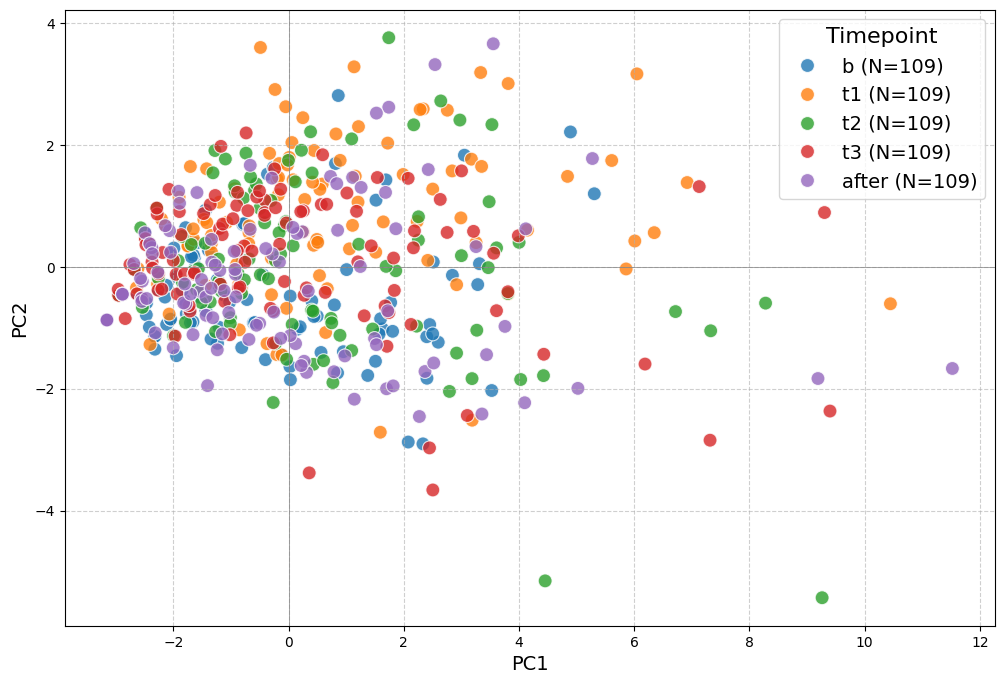

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. הגדרת הנתיב לקובץ ה-PCA שיצרנו
pca_file_path = r"only_Q_outputs/combined/combined_pca_components.csv"

# 2. טעינת הנתונים
pca_df = None
try:
    pca_df = pd.read_csv(pca_file_path)
except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")
    print("אנא ודא שהרצת את השלב הקודם ששומר את קובץ ה-PCA.")
    # raise
xlim = (pca_df['PC1'].min(), pca_df['PC1'].max())
ylim = (pca_df['PC2'].min(), pca_df['PC2'].max())
pad_x = 0.05 * (xlim[1] - xlim[0])
pad_y = 0.05 * (ylim[1] - ylim[0])

xlim = (xlim[0] - pad_x, xlim[1] + pad_x)
ylim = (ylim[0] - pad_y, ylim[1] + pad_y)

# 3. הכנה לתוספות הסטטיסטיות (נדרש רק אם ה-DataFrame נטען)
if pca_df is not None:
    # --- חישוב מספר נקודות הנתונים הכולל ---
    total_datapoints = len(pca_df)

    # --- חישוב גודל כל קבוצה (timepoint) לצורך עדכון המקרא ---
    group_counts = pca_df['timepoint'].value_counts().sort_index()
# --- יצירת עמודת מקרא חדשה המשלבת את שם הקבוצה ואת גודלה ---
# Correct dictionary comprehension syntax:
legend_map = {tp: f"{tp} (N={count})" for tp, count in group_counts.items()}

# יצירת העמודה החדשה שבה נשתמש ל-hue
pca_df['Legend_Label'] = pca_df['timepoint'].map(legend_map)
    # 4. יצירת הגרף עם Seaborn
plt.figure(figsize=(12, 8))

sns.scatterplot(
        data=pca_df,
        x='PC1',
        y='PC2',
        hue='Legend_Label',
        s=100,
        alpha=0.8
    )

plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Timepoint', fontsize=14, title_fontsize=16)

plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)

plt.show()


## mark subjects trajectory on the pca data

נמצאו 109 נבדקים המופיעים 5 פעמים. הם יודגשו בצבע.

הגרף נשמר בהצלחה ב: only_Q_outputs/combined/pca_plot_by_subject_5_times.png


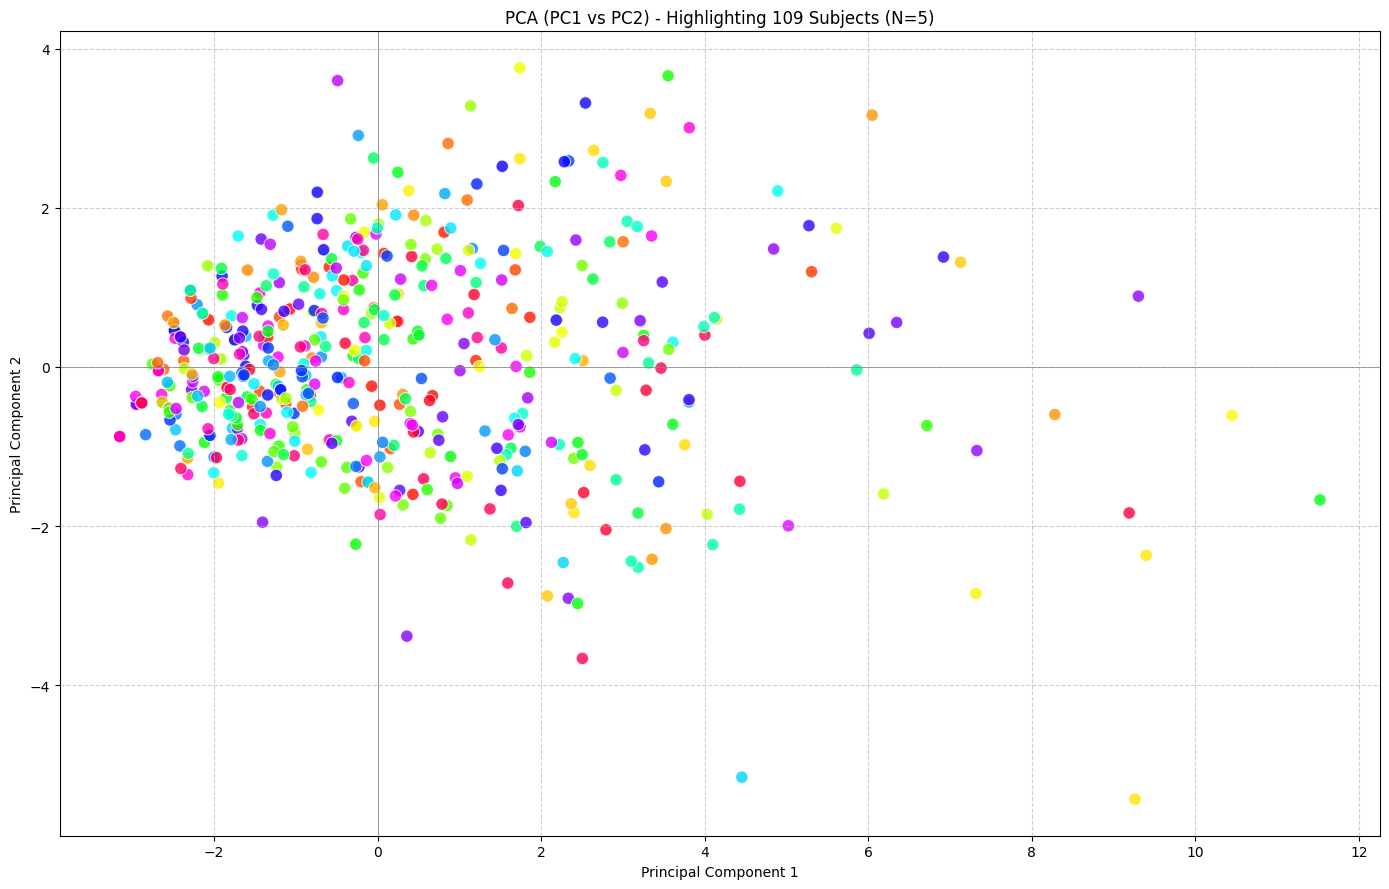

In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. הגדרת הנתיב לקובץ ה-PCA
pca_file_path = "only_Q_outputs/combined/combined_pca_components.csv"
save_path = "only_Q_outputs/combined/pca_plot_by_subject_5_times.png"

try:
    # 2. טעינת הנתונים
    pca_df = pd.read_csv(pca_file_path)

    # 3. זיהוי הנבדקים שמופיעים 5 פעמים
    # ספירת מופעים לכל נבדק
    subject_counts = pca_df['Subject_Code'].value_counts()

    # יצירת רשימה של שמות הנבדקים שמופיעים בדיוק 5 פעמים
    subjects_to_highlight = subject_counts[subject_counts == 5].index.tolist()

    if not subjects_to_highlight:
        print("לא נמצאו נבדקים המופיעים בדיוק 5 פעמים.")
    else:
        print(f"נמצאו {len(subjects_to_highlight)} נבדקים המופיעים 5 פעמים. הם יודגשו בצבע.")

    # 4. יצירת עמודת צביעה חדשה
    # ניצור עמודה ששומרת את שם הנבדק (אם הוא ברשימה) או 'Other' (אם לא)

    other_label = 'Other (N != 5)'

    def get_color_group(subject_code):
        if subject_code in subjects_to_highlight:
            return subject_code  # השאר את שם הנבדק
        else:
            return other_label # סמן כ"אחר"

    # החלת הפונקציה ליצירת העמודה החדשה
    pca_df['color_group'] = pca_df['Subject_Code'].apply(get_color_group)

    # 5. יצירת פלטת צבעים מותאמת
    # אנחנו רוצים שהקבוצה 'Other' תהיה אפורה, והשאר יהיו צבעוניים

    unique_groups = pca_df['color_group'].unique().tolist()
    palette_dict = {}

    # חישוב מספר הצבעים שנצטרך
    num_highlighted = len(unique_groups) - (1 if other_label in unique_groups else 0)

    if num_highlighted > 0:
        # שימוש בפלטת צבעים מגוונת (hsv) כי יש 79 נבדקים
        colors = sns.color_palette('hsv', n_colors=num_highlighted)
    else:
        colors = []

    color_idx = 0
    for group in unique_groups:
        if group == other_label:
            palette_dict[group] = 'lightgrey' # צבע אפור בהיר לרקע
        else:
            palette_dict[group] = colors[color_idx]
            color_idx += 1

    # 6. יצירת הגרף
    plt.figure(figsize=(14, 9))

    sns.scatterplot(
        data=pca_df,
        x='PC1',
        y='PC2',
        hue='color_group',    # צביעה לפי הקבוצה החדשה שיצרנו
        palette=palette_dict, # שימוש בפלטת הצבעים המותאמת
        s=80,
        alpha=0.8,
        legend=False          # <-- החלטנו לא להציג את המקרא כי 79 שמות זה יותר מדי
    )

    # 7. הוספת כותרות ושיפורים
    plt.title(f'PCA (PC1 vs PC2) - Highlighting {len(subjects_to_highlight)} Subjects (N=5)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)

    plt.tight_layout() # התאמה אוטומטית של הגבולות

    # 8. שמירת הגרף
    plt.savefig(save_path, dpi=150)
    print(f"\nהגרף נשמר בהצלחה ב: {save_path}")

except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")
except Exception as e:
    print(f"אירעה שגיאה: {e}")

In [128]:
import pandas as pd

pca_file_path = "only_Q_outputs/combined/combined_pca_components.csv"

try:
    pca_df = pd.read_csv(pca_file_path)

    # זיהוי הנבדקים שמופיעים 5 פעמים
    subject_counts = pca_df['Subject_Code'].value_counts()
    subjects_with_5 = subject_counts[subject_counts == 5].index.tolist()

    print(f"--- רשימת {len(subjects_with_5)} הנבדקים לבחירה (מופיעים 5 פעמים) ---")
    # הדפסת הרשימה בפורמט שקל להעתיק
    print(subjects_with_5)

except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")

--- רשימת 109 הנבדקים לבחירה (מופיעים 5 פעמים) ---
['NT005', 'NT002', 'NT001', 'NT007', 'CT004', 'CT003', 'NT010', 'CT005', 'NT008', 'NT016', 'NT018', 'NT017', 'CT008', 'NT019', 'CT007', 'NT015', 'NT022', 'CT010', 'CT015', 'CT013', 'NT024', 'CT012', 'NT026', 'CT016', 'NT028', 'NT032', 'NT023', 'NT035', 'NT036', 'NT027', 'NT033', 'NT031', 'NT025', 'NT034', 'NT042', 'NT040', 'NT046', 'NT048', 'NT049', 'CT022', 'NT039', 'CT023', 'NT055', 'NT058', 'NT059', 'NT057', 'NT041', 'CT024', 'NT051', 'NT060', 'NT047', 'CT025', 'CT028', 'CT029', 'NT065', 'NT067', 'CT031', 'CT026', 'CT027', 'NT044', 'NT070', 'NT071', 'NT074', 'CT034', 'NT069', 'NT076', 'NT078', 'NT082', 'NT084', 'CT038', 'NT085', 'CT033', 'NT087', 'CT041', 'NT063', 'NT089', 'CT040', 'CT039', 'NT090', 'NT096', 'NT091', 'NT077', 'NT097', 'NT081', 'CT047', 'CT046', 'CT045', 'NT030', 'CT044', 'NT100', 'NT094', 'CT050', 'CT051', 'NT118', 'NT116', 'NT121', 'CT055', 'NT123', 'NT114', 'NT124', 'NT107', 'CT058', 'NT126', 'CT060', 'CT062', 'CT

הנבדקים שנבחרו ידנית להדגשה: ['CT003', 'CT039', 'CT058', 'NT046', 'NT061', 'NT085', 'NT018', 'CT050', 'CT100', 'CT004']

הגרף נשמר בהצלחה ב: only_Q_outputs/combined/pca_plot_10_manual_subjects.png


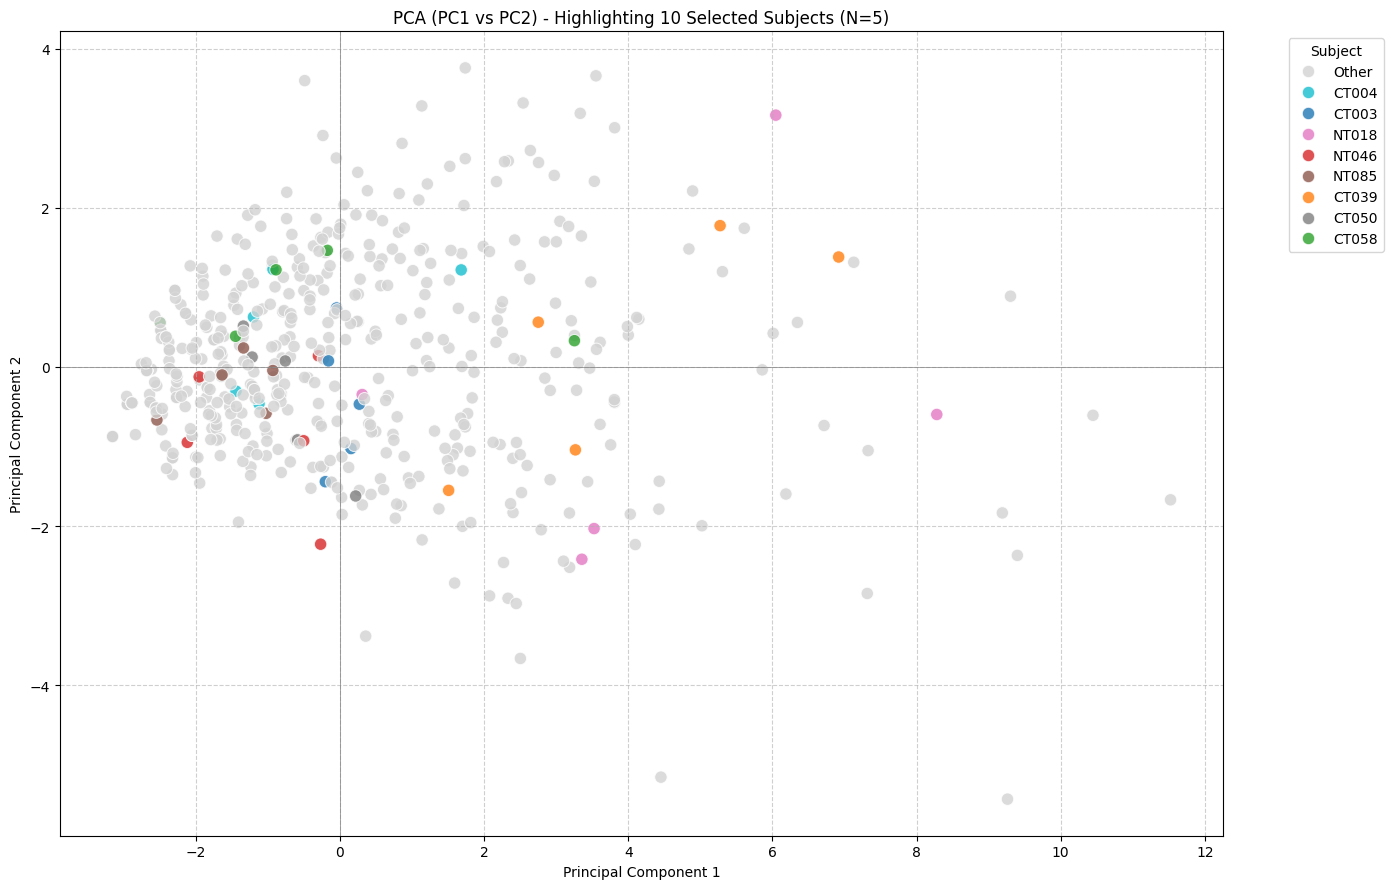

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. הגדרת הנתיב לקובץ ה-PCA
pca_file_path = "only_Q_outputs/combined/combined_pca_components.csv"
save_path = "only_Q_outputs/combined/pca_plot_10_manual_subjects.png"

try:
    # 2. טעינת הנתונים
    pca_df = pd.read_csv(pca_file_path)

    # ==========================================================
    #               👇 כאן להדביק את הבחירה שלך 👇
    # ==========================================================

    # 💡 הוראות:
    # העתק 10 שמות מהרשימה שהודפסה בשלב 1
    # והדבק אותם כאן. למשל:
    # ['NT085', 'NT015', 'CT061', 'NT002', 'NT030', 'NT126', 'NT039', 'CT029', 'CT008', 'CT013']

    subjects_to_highlight = [
        # הדבק כאן 10 שמות, כל אחד במרכאות ומופרד בפסיק
        'CT003', 'CT039', 'CT058', 'NT046', 'NT061',
        'NT085', 'NT018', 'CT050', 'CT100', 'CT004'
    ]

    # ==========================================================
    #               👆 סוף אזור הבחירה 👆
    # ==========================================================

    print(f"הנבדקים שנבחרו ידנית להדגשה: {subjects_to_highlight}")

    # 5. יצירת עמודת צביעה חדשה
    other_label = 'Other'

    def get_color_group(subject_code):
        if subject_code in subjects_to_highlight:
            return subject_code  # השאר את שם הנבדק
        else:
            return other_label # סמן כ"אחר"

    pca_df['color_group'] = pca_df['Subject_Code'].apply(get_color_group)

    # 6. יצירת פלטת צבעים מותאמת (10 צבעים + אפור)
    palette_dict = {}
    colors = sns.color_palette("tab10", n_colors=10)

    for i, subject in enumerate(subjects_to_highlight):
        palette_dict[subject] = colors[i]

    palette_dict[other_label] = 'lightgrey'

    # 7. יצירת הגרף
    plt.figure(figsize=(14, 9))

    sns.scatterplot(
        data=pca_df,
        x='PC1',
        y='PC2',
        hue='color_group',    # צביעה לפי הקבוצה החדשה
        palette=palette_dict, # שימוש בפלטת הצבעים המותאמת
        s=80,
        alpha=0.8,
        legend='full'         # הפעם נציג את המקרא
    )

    # 8. הוספת כותרות ושיפורים
    plt.title(f'PCA (PC1 vs PC2) - Highlighting 10 Selected Subjects (N=5)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)

    plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # 9. שמירת הגרף
    plt.savefig(save_path, dpi=150)
    print(f"\nהגרף נשמר בהצלחה ב: {save_path}")

except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")
except Exception as e:
    print(f"אירעה שגיאה: {e}")

## clustering using k means in each time point separately

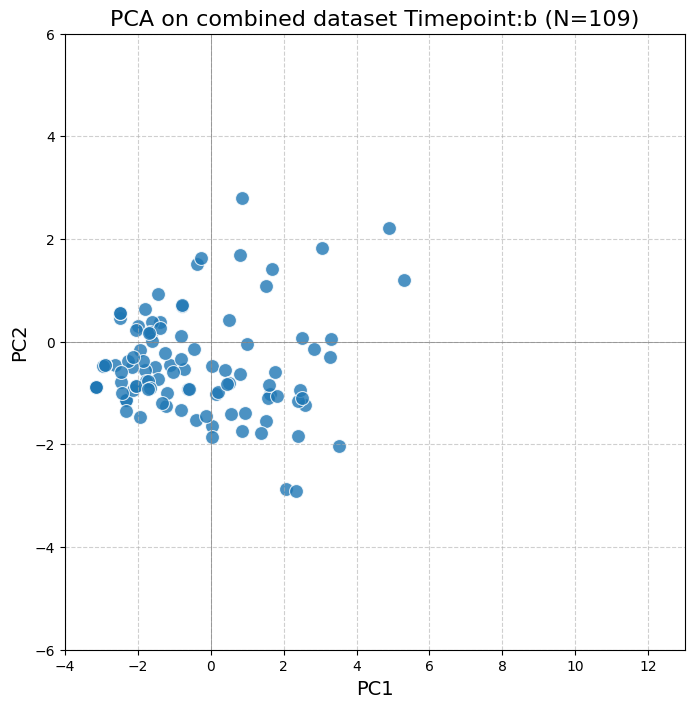

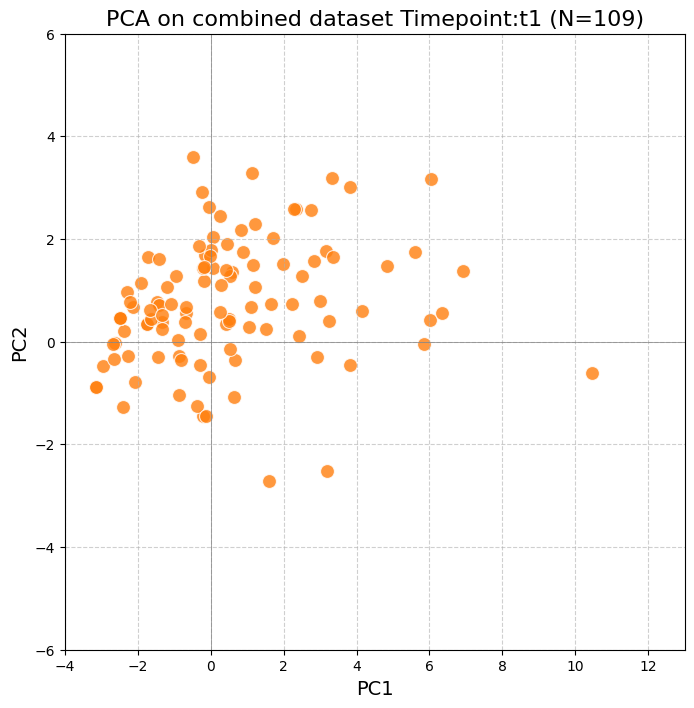

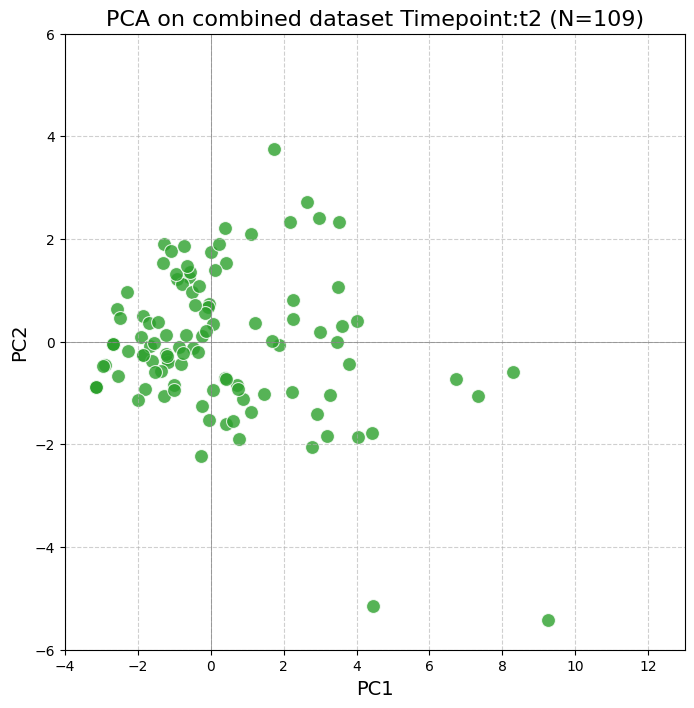

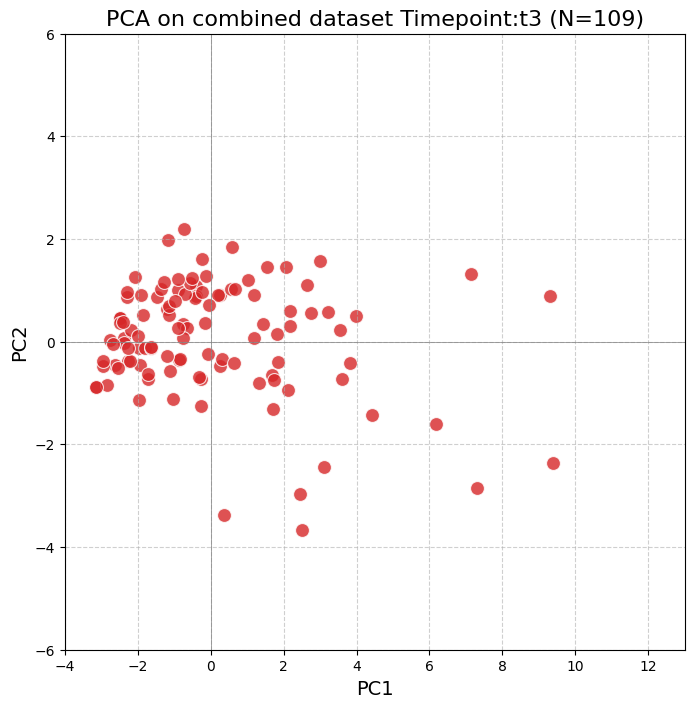

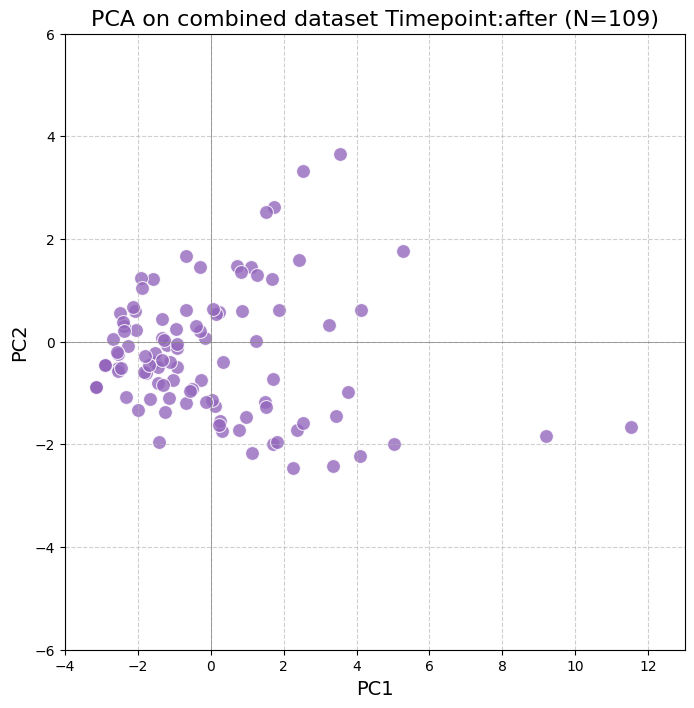

In [130]:

import matplotlib.pyplot as plt
import seaborn as sns
timepoint_order = ['b', 't1', 't2', 't3', 'after']
palette = sns.color_palette("tab10", n_colors=len(timepoint_order))

timepoint_colors = dict(zip(timepoint_order, palette))

timepoints = ['b', 't1', 't2', 't3', 'after']



for tp in timepoints:

    df_tp = pca_df[pca_df['timepoint'] == tp]

    plt.figure(figsize=(8, 8))

    sns.scatterplot(
        data=df_tp,
        x='PC1',
        y='PC2',
        s=100,
        alpha=0.8,
        color=timepoint_colors[tp]
    )

    # 🔑 SAME AXES AS COMBINED
    plt.xlim((-4,13))
    plt.ylim((-6,6))

    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.xlabel("PC1", fontsize=14)
    plt.ylabel("PC2", fontsize=14)
    plt.title(f"PCA on combined dataset Timepoint:{tp} (N={len(df_tp)})", fontsize=16)

    plt.show()



## k means on the combined pca  dataset


Cluster assignments saved to only_Q_outputs/combined/clusters_combined.csv


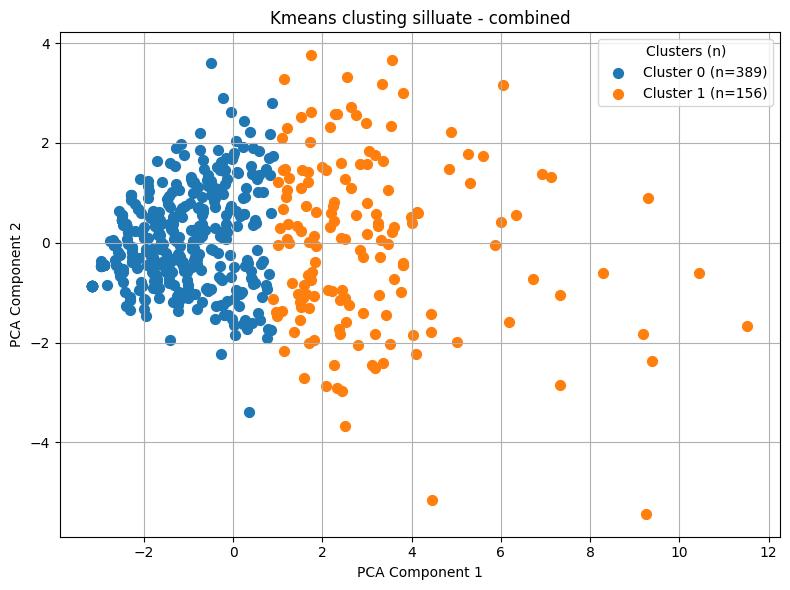

אירעה שגיאה: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


In [131]:

labels_comb_sil, data_pca_comb_sil, model_comb_sil, pca_comb_sil, = run_kmeans_clustering(
    df=df_combined,
    prefix="",  # your prefix
    n_components=n_dims_comb_90,
    k=best_k_comb_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - combined",
    csv_path="only_Q_outputs/combined/clusters_combined.csv",  include_timepoints=True)


# 1. הגדרת נתיבי הקבצים
pca_data_path = "only_Q_outputs/combined/combined_pca_components.csv"
cluster_data_path = "only_Q_outputs/combined/clusters_combined.csv"

# נתיב שמירה חדש לטבלת הסיכום
summary_save_path = "only_Q_outputs/combined_no_pca/cluster_timepoint_summary.csv"

try:
    # 2. טעינת שני קבצי התוצאות
    pca_df = data_pca_comb_sil
    cluster_df = pd.read_csv(cluster_data_path)

    # 3. מיזוג הקבצים
    merged_df = pd.merge(
        pca_df[['Subject_Code', 'timepoint', 'PC1', 'PC2']],
        cluster_df[['Subject_Code', 'timepoint', 'cluster']],
        on=['Subject_Code', 'timepoint']
    )

    # ==========================================================
    #         👇 הוספת הקוד לסיכום הנתונים 👇
    # ==========================================================

    # 4. יצירת טבלת הסיכום (crosstab)
    #    האשכולות יהיו השורות, ונקודות הזמן יהיו העמודות
    summary_table = pd.crosstab(
        index=merged_df['cluster'],     # השורות
        columns=merged_df['timepoint'], # העמודות
        margins=True,                   # הוסף שורת ועמודת "סך הכל"
        margins_name="Total"            # קרא לסך הכל "Total"
    )

    # 5. הדפסת הטבלה למסך
    print("--- סיכום נבדקים: אשכול מול נקודת זמן ---")
    print(summary_table)

    # 6. שמירת הטבלה לקובץ CSV
    summary_table.to_csv(summary_save_path)
    print(f"\nטבלת הסיכום נשמרה ב: {summary_save_path}")

    # ==========================================================
    #                  👆 סוף הקוד לסיכום 👆
    # ==========================================================

    # (הקוד הקודם לשרטוט הגרף יכול להמשיך מכאן אם תרצה)

except FileNotFoundError as e:
    print(f"שגיאה: הקובץ לא נמצא. אנא ודא ששני הקבצים קיימים בנתיבים הנכונים.")
    print(e)
except Exception as e:
    print(f"אירעה שגיאה: {e}")

## k meand per timepoint on the pca combined dataset


--- Running clustering for EACH timepoint ---

================ Running for timepoint: b ================
Cluster assignments saved to only_Q_outputs/combined/clusters_b.csv


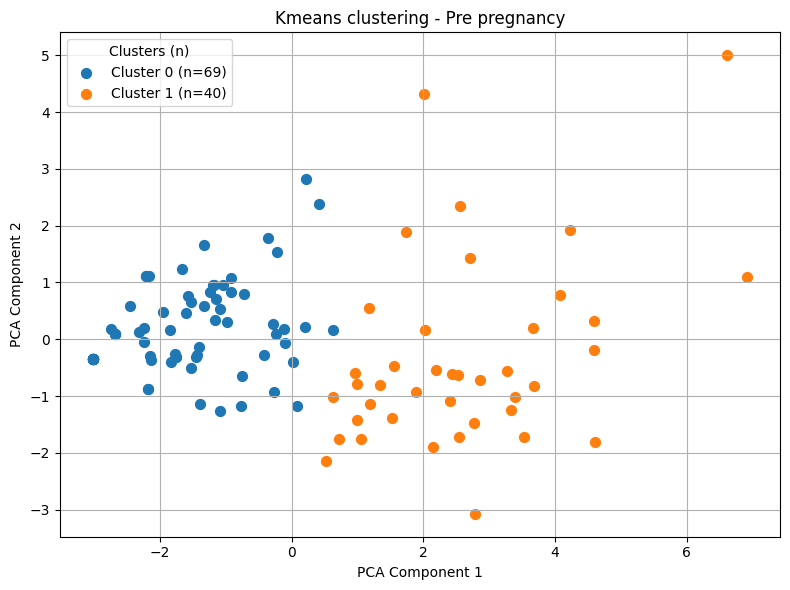


================ Running for timepoint: t1 ================
Cluster assignments saved to only_Q_outputs/combined/clusters_t1.csv


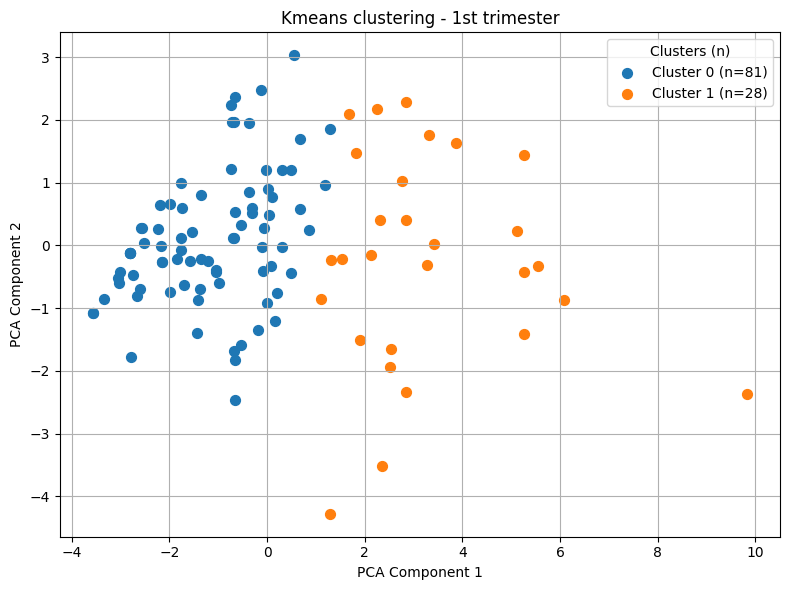


================ Running for timepoint: t2 ================
Cluster assignments saved to only_Q_outputs/combined/clusters_t2.csv


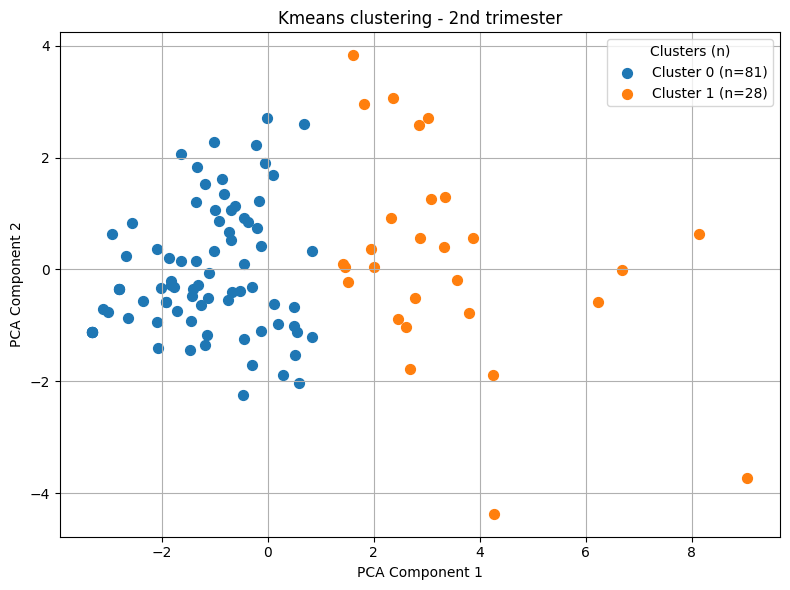


================ Running for timepoint: t3 ================
Cluster assignments saved to only_Q_outputs/combined/clusters_t3.csv


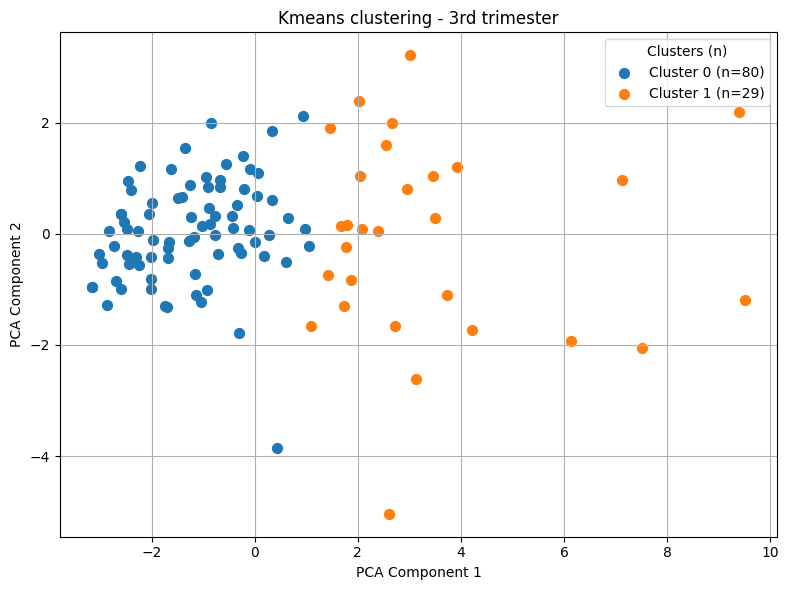


================ Running for timepoint: after ================
Cluster assignments saved to only_Q_outputs/combined/clusters_after.csv


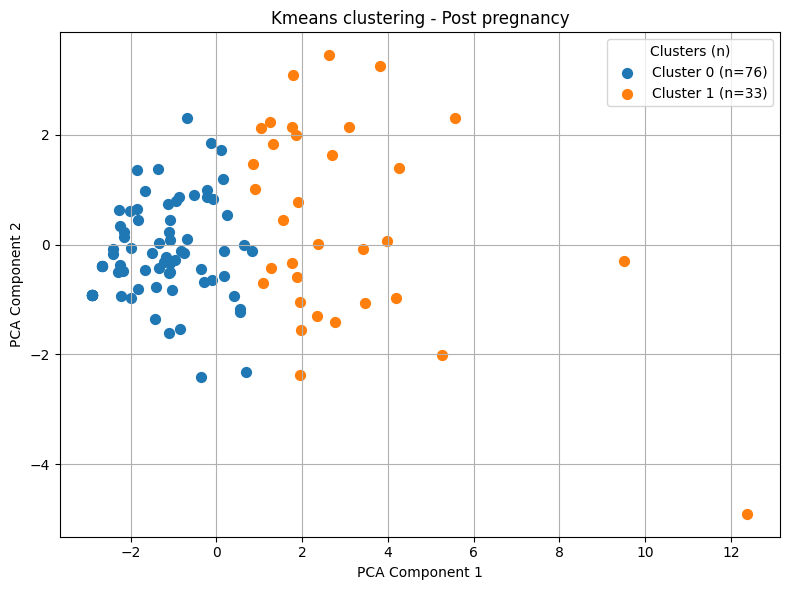


✅ All timepoints processed.
--- Generating final 2x3 combined plot ---


C:\Users\nogag\AppData\Local\Temp\ipykernel_5372\3134757102.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


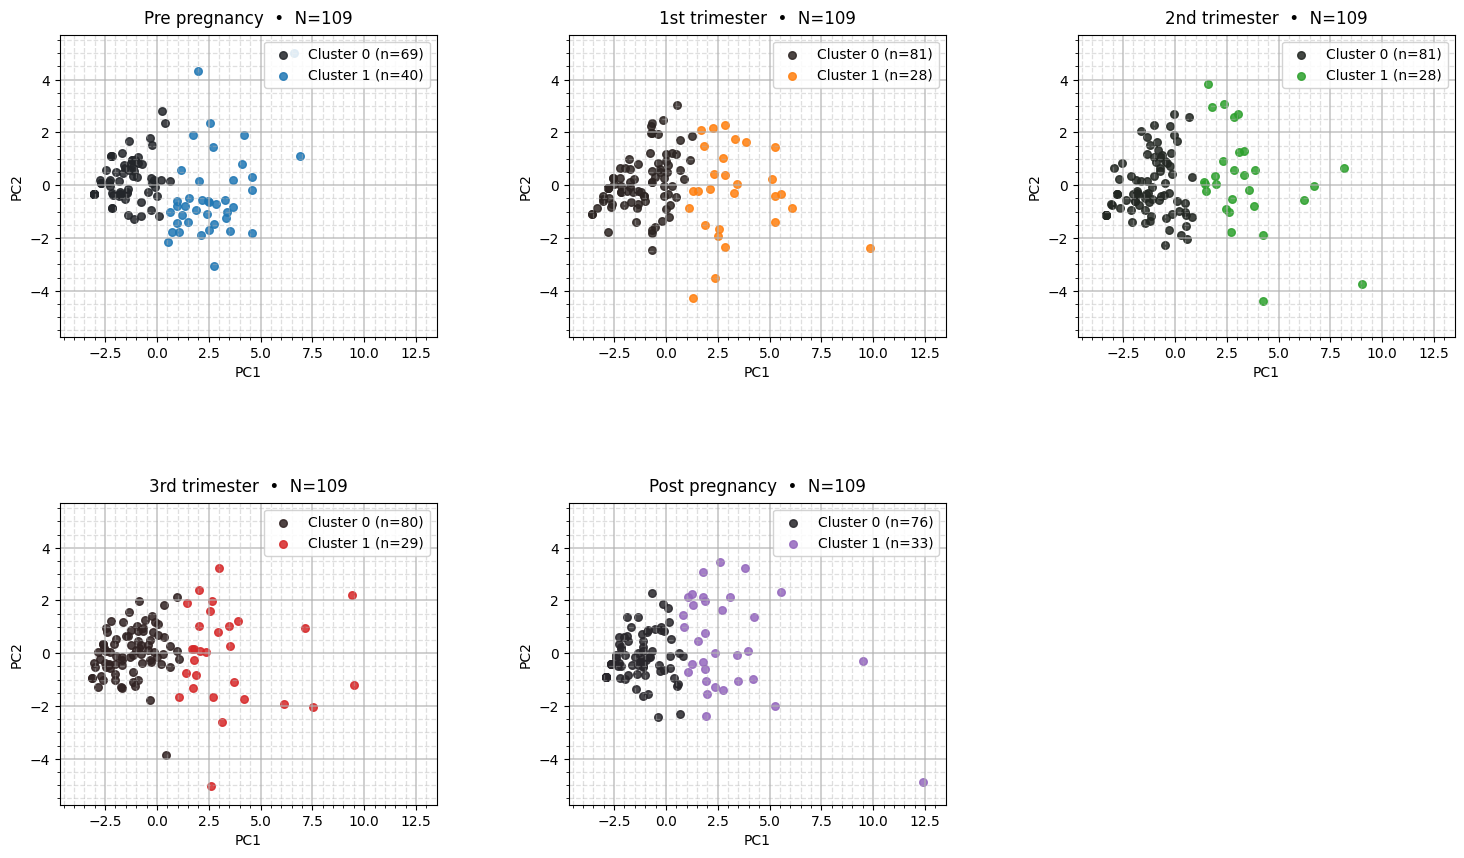

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import math
import seaborn as sns # נדרש עבור _pick_palette_for_labels

# ===================================================================
#           חלק 1: הגדרת כל הפונקציות הנדרשות
# ===================================================================

# --- פונקציית עזר 1 (נדרשת ע"י פונקציית השרטוט) ---
def _auto_layout(n, max_cols=3):
    """Calculates the number of rows and columns for subplots."""
    nrows = math.ceil(n / max_cols)
    ncols = min(n, max_cols)
    return nrows, ncols

def _pick_palette_for_labels(base_color, unique_labels):
    """Creates a color palette for a set of labels."""
    n_colors = len(unique_labels)
    if n_colors == 1:
        return {unique_labels[0]: base_color}
    try:
        colors = sns.dark_palette(base_color, n_colors=n_colors)
        return {lab: color for lab, color in zip(unique_labels, colors)}
    except Exception:
        colors = sns.color_palette(n_colors=n_colors)
        return {lab: color for lab, color in zip(unique_labels, colors)}

def plot_multi_dataset_scatters_colored(
    datasets,
    titles=None,
    labels_list=None,
    x_idx=0,
    y_idx=1,
    figsize=(18, 10),
    point_size=30,
    alpha=0.85,
    base_colors=None,
    wspace=0.35,
    hspace=0.55,
    axes_bg="white",
    max_cols=3,
    legend_loc="best",
    sort_labels=True,
    show_counts=True,
    show_percent=False,
    pad_frac=0.07,
    equal_aspect=False
):
    n = len(datasets)
    if base_colors is None:
        base_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red",
                       "tab:purple", "tab:brown", "tab:pink", "tab:olive", "tab:cyan"]

    if len(base_colors) < n:
        cycles_needed = math.ceil(n / len(base_colors))
        base_colors = (base_colors * cycles_needed)[:n]

    # --------- GLOBAL limits ----------
    all_x, all_y = [], []
    for data in datasets:
        if data is None or len(data) == 0:
            continue
        x = np.asarray(data[:, x_idx], dtype=float)
        y = np.asarray(data[:, y_idx], dtype=float)
        all_x.append(x[np.isfinite(x)])
        all_y.append(y[np.isfinite(y)])

    if all_x and all_y:
        all_x = np.concatenate(all_x)
        all_y = np.concatenate(all_y)

        global_x_min, global_x_max = float(np.min(all_x)), float(np.max(all_x))
        global_y_min, global_y_max = float(np.min(all_y)), float(np.max(all_y))

        x_pad = (global_x_max - global_x_min) * pad_frac if global_x_max > global_x_min else 1.0
        y_pad = (global_y_max - global_y_min) * pad_frac if global_y_max > global_y_min else 1.0

        x_lims = (global_x_min - x_pad, global_x_max + x_pad)
        y_lims = (global_y_min - y_pad, global_y_max + y_pad)
    else:
        x_lims, y_lims = None, None

    # --------- GRID ----------
    nrows, ncols = _auto_layout(n, max_cols=max_cols)
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=figsize,
        sharex=True, sharey=True,
        gridspec_kw={"wspace": wspace, "hspace": hspace}
    )
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    for i, data in enumerate(datasets):
        ax = axes[i]
        ax.set_facecolor(axes_bg)

        if x_lims is not None:
            ax.set_xlim(x_lims)
            ax.set_ylim(y_lims)

        if equal_aspect:
            ax.set_aspect('equal', adjustable='box')

        if data is None or labels_list is None or labels_list[i] is None:
            ax.text(0.5, 0.5, f"No data for {titles[i] if titles else ''}",
                    ha='center', va='center', transform=ax.transAxes, color='red')
            ax.set_title(titles[i] if titles else '', pad=8)
            ax.grid(True, which="major", linestyle="-", alpha=0.35)
            continue

        labels = np.asarray(labels_list[i])
        x = data[:, x_idx]
        y = data[:, y_idx]

        unique_labels = [lab for lab in np.unique(labels) if lab == lab]
        if sort_labels:
            try:
                unique_labels = np.sort(unique_labels)
            except Exception:
                pass

        total_n = int(np.sum(~np.isnan(labels))) if np.issubdtype(labels.dtype, np.floating) else len(labels)
        palette = _pick_palette_for_labels(base_colors[i], unique_labels)

        for lab in unique_labels:
            mask = labels == lab
            n_lab = int(np.sum(mask))
            if n_lab == 0:
                continue

            legend_text = f"Cluster {lab}"
            if show_counts:
                if show_percent and total_n > 0:
                    legend_text += f" (n={n_lab}, {n_lab/total_n:.0%})"
                else:
                    legend_text += f" (n={n_lab})"

            ax.scatter(
                x[mask], y[mask],
                s=point_size, alpha=alpha,
                color=palette[lab], label=legend_text
            )

        ax.legend(fontsize=10, frameon=True, framealpha=0.85, loc='upper right')
        ax.set_xlabel(f"PC{x_idx+1}")
        ax.set_ylabel(f"PC{y_idx+1}")

        if titles is not None and i < len(titles):
            ttl = f"{titles[i]}  •  N={total_n}" if show_counts else titles[i]
            ax.set_title(ttl, pad=8)

        # ---- FORCE axis tick labels on ALL subplots ----
        ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)

        # ---- FORCE grid lines inside each subplot ----
 # ---- darker grid ----
        ax.grid(True, which="major", linestyle="-", linewidth=1.2, alpha=0.70)
        ax.minorticks_on()
        ax.grid(True, which="minor", linestyle="--", linewidth=0.9, alpha=0.40)

    for j in range(len(datasets), nrows * ncols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# ===================================================================
#           חלק 2: הרצת הניתוח
# ===================================================================


# --- שלב ב': הרצת הלולאה עבור כל נקודת זמן ---
# הגדרת סדר נקודות הזמן והכותרות
timepoint_map = {
    'b': "Pre pregnancy",
    't1': "1st trimester",
    't2': "2nd trimester",
    't3': "3rd trimester",
    'after': "Post pregnancy"
}
plot_order = ['b', 't1', 't2', 't3', 'after'] # הסדר הרצוי לפאנלים

results_by_timepoint = {}

print("\n--- Running clustering for EACH timepoint ---")
for tp in plot_order:
    if tp not in df_combined['timepoint'].unique():
        print(f"Warning: Timepoint '{tp}' not found in df_combined. Skipping.")
        results_by_timepoint[tp] = {'labels': None, 'data_pca': None} # Placeholder
        continue

    print(f"\n================ Running for timepoint: {tp} ================")
    df_t = df_combined[df_combined['timepoint'] == tp].copy()

    csv_path_t = f"only_Q_outputs/combined/clusters_{tp}.csv"
    title_t = f"Kmeans clustering - {timepoint_map[tp]}"

    # (שים לב: plot=True כאן יציג גרף נפרד *לכל* נקודת זמן)
    labels_t, data_pca_t, kmeans_t, pca_t= run_kmeans_clustering(
        df=df_t,
        prefix="",
        n_components=n_dims_comb_90,
        k=best_k_comb_sil,
        plot=True, # <-- שנה ל-False אם אינך רוצה לראות 5 גרפים נפרדים
        title=title_t,
        csv_path=csv_path_t
    )

    results_by_timepoint[tp] = {
        'labels': labels_t,
        'data_pca': data_pca_t
    }

print("\n✅ All timepoints processed.")

# --- שלב ג': איסוף התוצאות והכנה לשרטוט המאוחד ---
print("--- Generating final 2x3 combined plot ---")

# בניית הרשימות עבור פונקציית השרטוט
datasets_to_plot = [results_by_timepoint[tp]['data_pca'] for tp in plot_order]
labels_to_plot = [results_by_timepoint[tp]['labels'] for tp in plot_order]
titles_for_plot = [timepoint_map[tp] for tp in plot_order]



# הגדרת 6 צבעי בסיס
base_colors_for_plot = [
    "tab:blue", "tab:orange", "tab:green",
    "tab:red", "tab:purple", 
]

plot_multi_dataset_scatters_colored(
    datasets=datasets_to_plot,
    titles=titles_for_plot,
    labels_list=labels_to_plot,
    x_idx=0, y_idx=1,
    base_colors=base_colors_for_plot,
    show_counts=True,
    max_cols=3
)


## plot the clustering of the combined dataset


C:\Users\nogag\AppData\Local\Temp\ipykernel_5372\3134757102.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


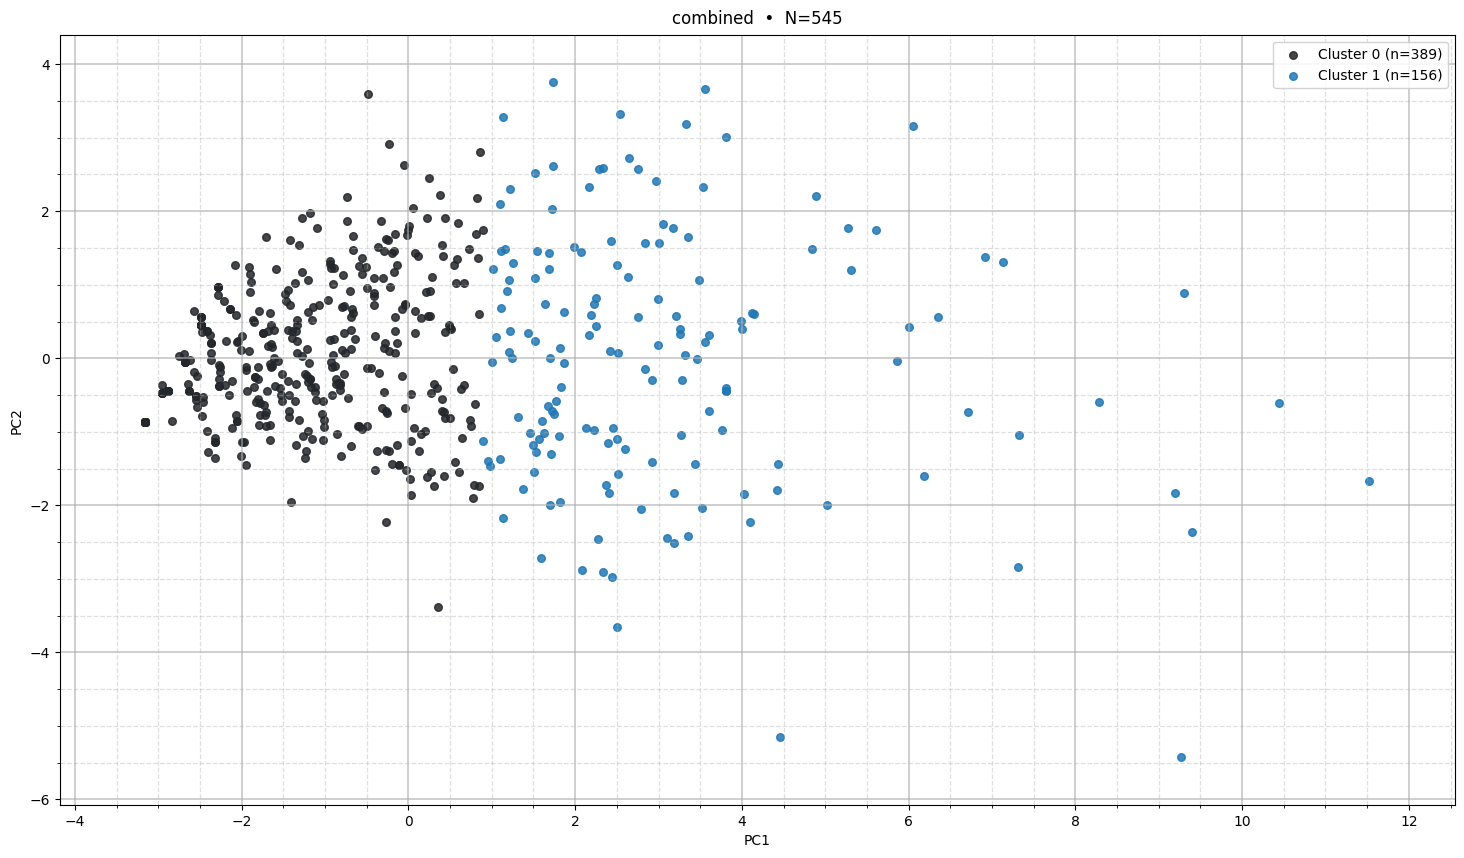

In [133]:
plot_multi_dataset_scatters_colored(
    datasets=[data_pca_comb_sil],
    titles=["combined"],
    labels_list=[labels_comb_sil],
    x_idx=0, y_idx=1,
    base_colors=["tab:blue"],
    show_counts=True,  # <-- on
    show_percent=False  # <-- optional %
)

## plotting the losings for pc1 and pc2

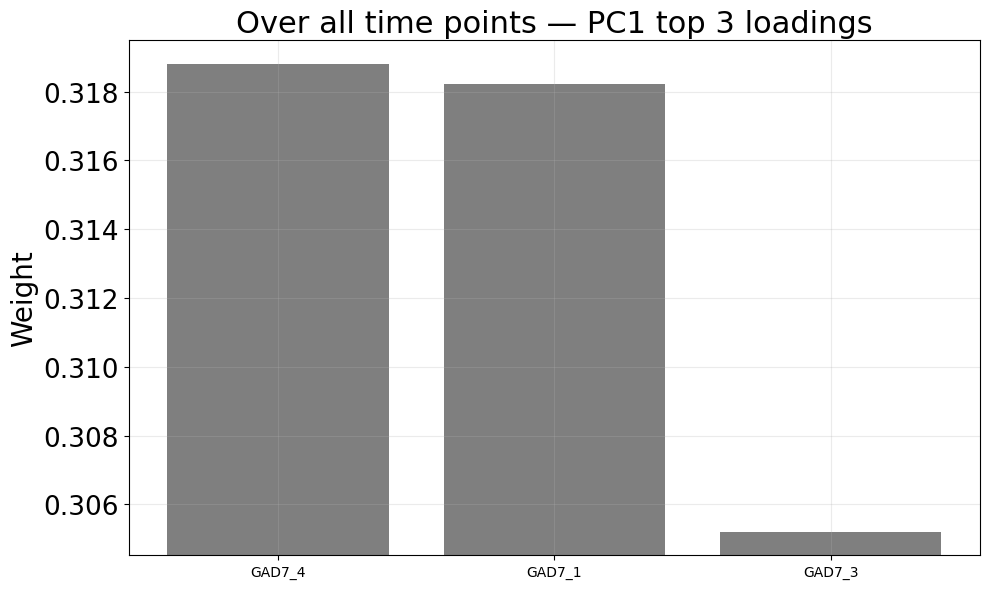

                dataset  pc  rank_within_dataset feature   loading  \
0  Over all time points   1                    1  GAD7_4  0.318810   
1  Over all time points   1                    2  GAD7_1  0.318225   
2  Over all time points   1                    3  GAD7_3  0.305204   

   abs_loading  
0     0.318810  
1     0.318225  
2     0.305204  


In [134]:
# PC1 (pc_index=0), top 15:


FEATURE_MAPPING = {
    "GAD7_1": "felt nervous, anxious, or tense- GAD7_1",
    "GAD7_2": "Not being able to stop worry or control worrying- GAD7_2",
    "GAD7_3": "Worrying too much about different things- GAD7_3",
    "GAD7_4": "Trouble relaxing -GAD7_4",
    "GAD7_5": "Being so restless that it's hard to sit still-GAD7_5",
    "GAD7_6": "Becoming easily annoyed or irritable-GAD7_6",
    "GAD7_7": "Feeling afraid as if something awful might happen-GAD7_7",
    "PHQ_1": "Little interest or pleasure in doing things-PHQ_1",
    "PHQ_2": "Feeling down, depressed, or hopeless-PHQ_2",
    "PHQ_3": "Trouble falling or staying asleep, or sleeping too much-PHQ_3",
    "PHQ_4": "Feeling tired or having little energy-PHQ_4",
    "PHQ_5": "Poor appetite or overeating-PHQ_5",
    "PHQ_6": "Feeling bad about yourself, failure, or letting family down-PHQ_6",
    "PHQ_7": "Difficulty focusing on things like reading/TV-PHQ_7",
    "PHQ_8": "Changes in activity: Slowed speech/movement or restlessness/agitation-PHQ_8",
    "PHQ_9": "Thoughts of self-harm or death-PHQ_9",
}

df_pc1 = plot_pca_weights_separate_and_table(
    pcas=[pca_comb_sil],
    dfs=[df_combined],
    prefixes=[""],
    titles=["Over all time points"],
    pc_index=0,
    top_n=3,
    figsize=(10, 6),
    fontsize=20,
    colors=["tab:gray"],  #K
    save_csv_path="only_Q_outputs/combined/top_loadings_PC1.csv"
)

# הצצה לטבלה:
print(df_pc1.head(10))

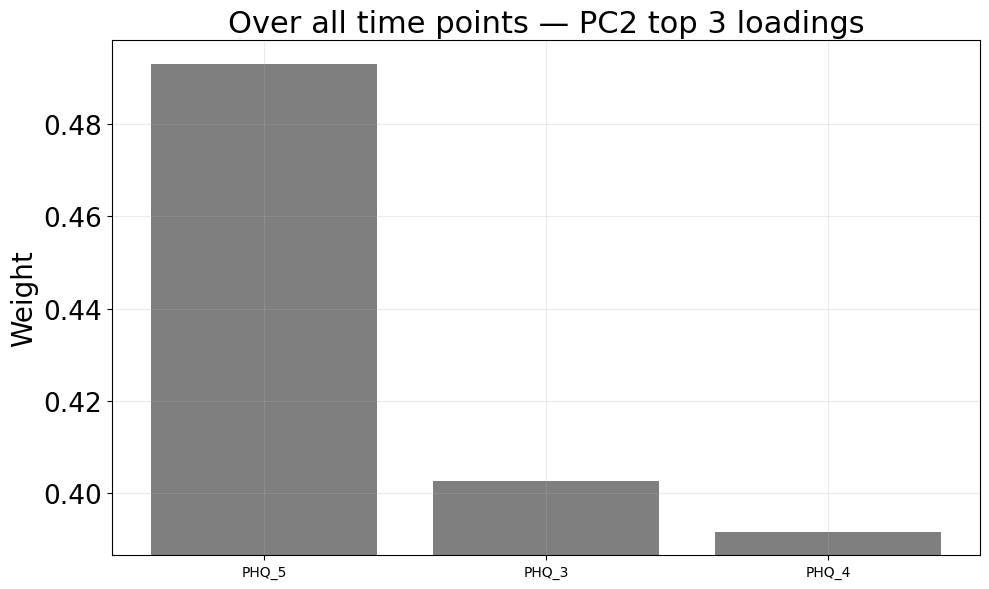

                dataset  pc  rank_within_dataset feature   loading  \
0  Over all time points   2                    1   PHQ_5  0.492994   
1  Over all time points   2                    2   PHQ_3  0.402579   
2  Over all time points   2                    3   PHQ_4  0.391655   

   abs_loading  
0     0.492994  
1     0.402579  
2     0.391655  


In [135]:

df_pc1 = plot_pca_weights_separate_and_table(
    pcas=[pca_comb_sil],
    dfs=[df_combined],
    prefixes=[""],
    titles=["Over all time points"],
    pc_index=1,
    top_n=3,
    figsize=(10, 6),
    fontsize=20,
    colors=["tab:gray"],  #K
    save_csv_path="only_Q_outputs/combined/top_loadings_PC1.csv"
)

# הצצה לטבלה:
print(df_pc1.head(10))

In [136]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA # Assuming this is the class used in pca_comb_sil

def save_all_pca_loadings_to_csv(
    pca_model,
    df_original,
    prefix="",
    save_csv_path="pca_all_loadings.csv"
):
    """
    Calculates the loadings (weights) for all Principal Components (PC1, PC2, etc.)
    and saves them to a CSV file.

    Parameters
    ----------
    pca_model : sklearn.decomposition.PCA
        The fitted PCA model (e.g., pca_comb_sil).
    df_original : pd.DataFrame
        The DataFrame containing the original features used for PCA (e.g., df_combined).
    prefix : str
        The prefix used to identify the relevant features in df_original.
    save_csv_path : str
        The path where the resulting CSV file will be saved.
    """
    
    # 1. Identify the original features used for the PCA model
    # Features must start with the given prefix and exclude specific columns.
    # Note: We assume the feature list logic from your previous function is correct.
    features = [c for c in df_original.columns
                if c.startswith(prefix) and 'lec' not in c and c != 'Subject_Code']

    n_components = pca_model.n_components_
    
    # Ensure the number of features matches the size of the components array
    if len(pca_model.components_[0]) != len(features):
        # Fallback: Trim features list to match the number of components weights
        # This assumes features were ordered correctly when fitting PCA.
        print(f"Warning: PCA components length ({len(pca_model.components_[0])}) does not match "
              f"identified feature count ({len(features)}). Trimming feature list.")
        features = features[:len(pca_model.components_[0])]
    
    # 2. Extract all loadings
    # pca_model.components_ is an array of shape (n_components, n_features)
    loadings_array = pca_model.components_[:, :len(features)].T
    
    # 3. Create the DataFrame
    # Rows: Features, Columns: PCs
    loadings_df = pd.DataFrame(
        loadings_array,
        index=features,
        columns=[f"PC{i+1}" for i in range(n_components)]
    )
    
    loadings_df = loadings_df.reset_index().rename(columns={'index': 'feature'})
    
    # 4. Save the result
    loadings_df.to_csv(save_csv_path, index=False)
    
    print(f"✅ Successfully calculated and saved loadings for {n_components} PCs.")
    print(f"📁 Output saved to: {save_csv_path}")
    
    return loadings_df



loadings_output_path = r"only_Q_outputs\combined\regression\pca_all_loadings_full_table.csv"

full_loadings_df = save_all_pca_loadings_to_csv(
    pca_model=pca_comb_sil,
    df_original=df_combined,
    prefix="", # Replace with the actual prefix used in your PCA fit
    save_csv_path=loadings_output_path
)

print("\nHead of the generated Loadings DataFrame:")
print(full_loadings_df.head())

✅ Successfully calculated and saved loadings for 12 PCs.
📁 Output saved to: only_Q_outputs\combined\regression\pca_all_loadings_full_table.csv

Head of the generated Loadings DataFrame:
  feature       PC1       PC2       PC3       PC4       PC5       PC6  \
0   PHQ_1  0.249018  0.155744  0.112904  0.020375  0.255546  0.639809   
1   PHQ_2  0.284112 -0.047272 -0.080322 -0.188569  0.067747  0.470963   
2   PHQ_3  0.202374  0.402579 -0.106951 -0.126976  0.319931 -0.232701   
3   PHQ_4  0.249954  0.391655 -0.186006 -0.049909  0.057032 -0.262697   
4   PHQ_5  0.191429  0.492994  0.098522 -0.041429 -0.117660 -0.103553   

        PC7       PC8       PC9      PC10      PC11      PC12  
0  0.074684 -0.182952 -0.125464  0.060831 -0.230001  0.254170  
1  0.089771 -0.144203 -0.155181  0.085433  0.476593 -0.271051  
2  0.497484  0.175845  0.140524 -0.065004 -0.045691  0.452205  
3  0.121317 -0.025104  0.114916  0.152235  0.387340 -0.445620  
4 -0.179893  0.037161 -0.559126 -0.193761 -0.400578 -0.

## merge the clusters from the diffrent time points into one csv

In [137]:
# Map each file to the column name you want in the merged table
files = {
    "only_Q_outputs/combined/clusters_b.csv": "b",
    "only_Q_outputs/combined/clusters_t1.csv": "t1",
    "only_Q_outputs/combined/clusters_t2.csv": "t2",
    "only_Q_outputs/combined/clusters_t3.csv": "t3",
    "only_Q_outputs/combined/clusters_after.csv": "after",

}


# Load and prepare all dataframes
dfs = [load_one(path, col) for path, col in files.items()]

# Outer-join on Subject_Code
merged = reduce(lambda left, right: pd.merge(left, right, on="Subject_Code", how="outer"), dfs)

# Replace NaN with None (optional)
merged = merged.where(pd.notna(merged), None)

# Save
merged.to_csv('only_Q_outputs/combined/clusters_merged_by_subject_from_combined.csv', index=False)
print("Saved: clusters_merged_by_subject.csv")
print(merged.head())

Saved: clusters_merged_by_subject.csv
  Subject_Code  b  t1  t2  t3  after
0        CT003  1   0   0   0      0
1        CT004  0   0   0   0      1
2        CT005  1   1   0   1      0
3        CT007  1   1   1   1      1
4        CT008  1   0   0   0      0


## aligning the clusters


In [138]:
invert_binary_columns(
    input_path="only_Q_outputs/combined/clusters_merged_by_subject_from_combined.csv",
    output_path='only_Q_outputs/combined/timepoints_file_inverted_2.csv',
    column_names=[]  # any set of binary columns
)

# invert_binary_columns(
#     input_path="only_Q_outputs/combined/clusters_combined.csv",
#     output_path='only_Q_outputs/combined/combined_file_inverted_2.csv',
#     column_names=["Cluster"]  # any set of binary columns
# )



✅ File saved to only_Q_outputs/combined/timepoints_file_inverted_2.csv


# find the threshold of each cluster 

## creating file for each time point with the cluster ( after aligning) anf the pca

In [139]:
import pandas as pd
from pathlib import Path

# =========================
# Load data
# =========================
timepoints = pd.read_csv(r"only_Q_outputs/combined/timepoints_file_inverted_2.csv")
pca = pd.read_csv(r"only_Q_outputs\combined\combined_pca_components.csv")

# =========================
# Column names (adjust if needed)
# =========================
subject_col = timepoints.columns[0]   # subject
timepoint_col = "timepoint"           # in PCA file

# =========================
# Output directory
# =========================
out_dir = Path(r"only_Q_outputs\combined\timepoint_files")
out_dir.mkdir(exist_ok=True)

# =========================
# Loop over timepoints
# =========================
for tp in timepoints.columns[1:]:  # skip subject column

    # ---- cluster info for this timepoint ----
    cluster_df = timepoints[[subject_col, tp]].rename(columns={tp: "cluster"})

    # ---- PCA rows ONLY for this timepoint ----
    pca_tp = pca[pca[timepoint_col] == tp]

    # ---- merge on subject ----
    out_df = pd.merge(
        cluster_df,
        pca_tp,
        on=subject_col,
        how="inner"
    )

    # ---- optional: drop timepoint column (since file = timepoint) ----
    out_df = out_df.drop(columns=[timepoint_col])

    # ---- save ----
    out_file = out_dir / f"timepoint_{tp}.csv"
    out_df.to_csv(out_file, index=False)

    print(f"Saved: {out_file}")


Saved: only_Q_outputs\combined\timepoint_files\timepoint_b.csv
Saved: only_Q_outputs\combined\timepoint_files\timepoint_t1.csv
Saved: only_Q_outputs\combined\timepoint_files\timepoint_t2.csv
Saved: only_Q_outputs\combined\timepoint_files\timepoint_t3.csv
Saved: only_Q_outputs\combined\timepoint_files\timepoint_after.csv


### find the line that seperat ethe clusters at each time point

## plotting the trajectory

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_subject_pca_trajectory(df, subject_code, pc_x="PC1", pc_y="PC2",
                                time_col="timepoint",
                                title=None, figsize=(8,6),
                                color="blue", marker="o"):
    sub_df = df[df["Subject_Code"] == subject_code].copy()
    if sub_df.empty:
        return
    sub_df = sub_df.sort_values(time_col)
    if title is None:
        title = f"PCA Trajectory — Subject {subject_code}"

    plt.figure(figsize=figsize)
    plt.plot(sub_df[pc_x], sub_df[pc_y], "-o", color=color, marker=marker,
             linewidth=2, markersize=10)

    for _, row in sub_df.iterrows():
        plt.text(row[pc_x], row[pc_y], f"{row[time_col]}",
                 fontsize=12, ha="left", va="bottom")

    plt.xlabel(pc_x)
    plt.ylabel(pc_y)
    plt.title(title, fontsize=16)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------------
# ⭐ NEW FUNCTION — CREATES PC1 AND PC2 TRAJECTORY CSV FILES
# -------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

def plot_subject_pca_trajectory(df, subject_code, pc_x="PC1", pc_y="PC2",
                                time_col="timepoint",
                                title=None, figsize=(8,6),
                                color="blue", marker="o"):

    sub_df = df[df["Subject_Code"] == subject_code].copy()
    if sub_df.empty:
        return

    sub_df = sub_df.sort_values(time_col)

    if title is None:
        title = f"PCA Trajectory — Subject {subject_code}"

    plt.figure(figsize=figsize)
    plt.plot(sub_df[pc_x], sub_df[pc_y], "-o", color=color, marker=marker,
             linewidth=2, markersize=10)

    for _, row in sub_df.iterrows():
        plt.text(row[pc_x], row[pc_y], f"{row[time_col]}",
                 fontsize=12, ha="left", va="bottom")

    plt.xlabel(pc_x)
    plt.ylabel(pc_y)
    plt.title(title, fontsize=16)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------------
# ⭐ NEW FUNCTION — EXPORT ALL PC TRAJECTORIES (PC1..PCn × timepoints)
# -------------------------------------------------------------------------
def export_all_pc_trajectories(
    df,
    subjects_with_5,
    timepoints=["b", "t1", "t2", "t3", "after"],
    output_csv="all_PC_trajectories.csv",
    plot_graphs=False
):

    df["Subject_Code"] = df["Subject_Code"].astype(str)

    # Detect all PC columns
    pc_names = [col for col in df.columns if col.startswith("PC")]

    rows = []

    for subj in subjects_with_5:

        sub_df = df[df["Subject_Code"] == str(subj)].copy()
        if len(sub_df) != len(timepoints):
            continue

        sub_df = sub_df.sort_values("timepoint")

        row_dict = {"Subject_Code": subj}

        # Fill values
        for tp in timepoints:
            df_tp = sub_df[sub_df["timepoint"] == tp]

            if df_tp.empty:
                for pc in pc_names:
                    row_dict[f"{pc}_{tp}"] = None
                continue

            for pc in pc_names:
                row_dict[f"{pc}_{tp}"] = df_tp[pc].values[0]

        rows.append(row_dict)

        if plot_graphs:
            plot_subject_pca_trajectory(
                df=sub_df,
                subject_code=subj,
                pc_x="PC1",
                pc_y="PC2",
                time_col="timepoint"
            )

    out_df = pd.DataFrame(rows)
    out_df.to_csv(output_csv, index=False)
    print(f"\nSaved full PC trajectories → {output_csv}")
    return out_df





# -------------------------------------------------------------------------
# ⭐ MAIN EXECUTION
# -------------------------------------------------------------------------


df = pd.read_csv("only_Q_outputs/combined/combined_pca_components.csv")

subjects_with_5 = (
    df.groupby("Subject_Code")
      .size()
      .reset_index(name="count")
      .query("count == 5")["Subject_Code"]
      .astype(str).tolist()
)

all_pc_df = export_all_pc_trajectories(
    df=df,
    subjects_with_5=subjects_with_5,
    timepoints=["b", "t1", "t2", "t3", "after"],
    output_csv="only_Q_outputs/combined/regression/ALL_PC_trajectories.csv",
    plot_graphs=False
)




Saved full PC trajectories → only_Q_outputs/combined/regression/ALL_PC_trajectories.csv


In [141]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"only_Q_outputs/combined/regression/ALL_PC_trajectories.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas.csv"

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)

# -------------------------
# 2. Select regression columns
# -------------------------


regression_cols =["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction','t1_MAAS_total','t2_MAAS_total','t3_MAAS_total']

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

pc_df_b = pc_df
# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
timepoints = ["b", "t1", "t2", "t3", "after"]

pc_cols = []

for col in pc_df.columns:
    if not col.startswith("PC"):
        continue

    # PC columns look like "PC3_t2", so split at the LAST underscore
    if "_" not in col:
        continue

    pc_name, tp = col.rsplit("_", 1)

    if tp in timepoints:
        pc_cols.append(col)

pc1_cols = ["Subject_Code"] +  pc_cols


pc_b = pc_df_b[pc1_cols].copy()


# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------



# -------------------------
# 6. Save result
# -------------------------

output_path = r"only_Q_outputs/combined/regression/subjects_ALL_PC_TRAJRCTORY_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - only_Q_outputs/combined/regression/subjects_ALL_PC_TRAJRCTORY_with_regression.csv


Subjects with 5 timepoints: ['CT003', 'CT004', 'CT005', 'CT007', 'CT008', 'CT010', 'CT012', 'CT013', 'CT015', 'CT016', 'CT022', 'CT023', 'CT024', 'CT025', 'CT026', 'CT027', 'CT028', 'CT029', 'CT031', 'CT033', 'CT034', 'CT038', 'CT039', 'CT040', 'CT041', 'CT044', 'CT045', 'CT046', 'CT047', 'CT050', 'CT051', 'CT055', 'CT058', 'CT060', 'CT061', 'CT062', 'NT001', 'NT002', 'NT005', 'NT007', 'NT008', 'NT010', 'NT015', 'NT016', 'NT017', 'NT018', 'NT019', 'NT022', 'NT023', 'NT024', 'NT025', 'NT026', 'NT027', 'NT028', 'NT030', 'NT031', 'NT032', 'NT033', 'NT034', 'NT035', 'NT036', 'NT039', 'NT040', 'NT041', 'NT042', 'NT044', 'NT046', 'NT047', 'NT048', 'NT049', 'NT051', 'NT055', 'NT057', 'NT058', 'NT059', 'NT060', 'NT063', 'NT065', 'NT067', 'NT069', 'NT070', 'NT071', 'NT074', 'NT076', 'NT077', 'NT078', 'NT081', 'NT082', 'NT084', 'NT085', 'NT087', 'NT089', 'NT090', 'NT091', 'NT094', 'NT096', 'NT097', 'NT100', 'NT107', 'NT114', 'NT116', 'NT118', 'NT121', 'NT123', 'NT124', 'NT126', 'NT129', 'NT131',

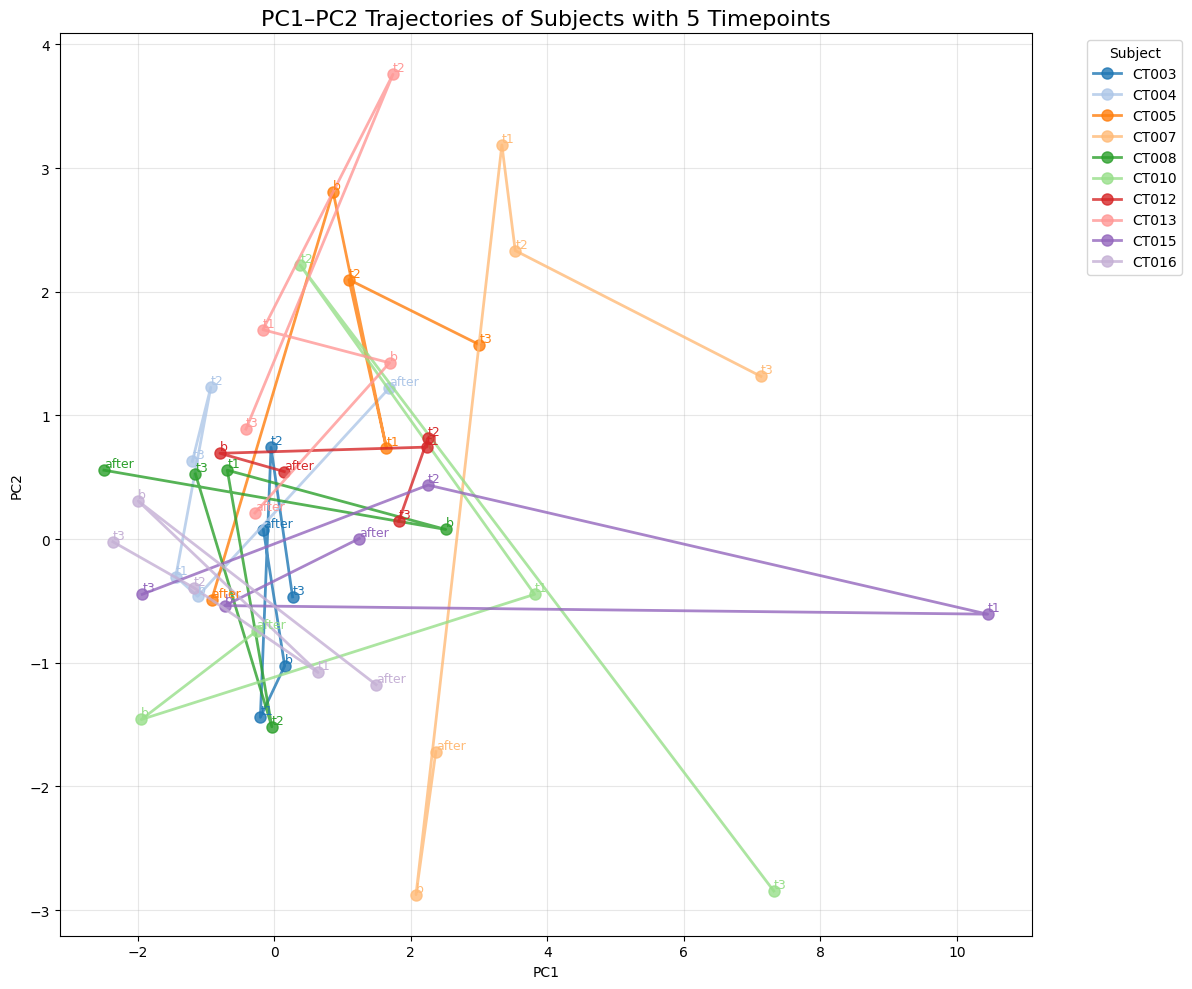

In [142]:
df = pd.read_csv("only_Q_outputs/combined/combined_pca_components.csv")

subjects_with_5 = (
    df.groupby("Subject_Code")
      .size()
      .reset_index(name="count")
      .query("count == 5")["Subject_Code"]
      .tolist()
)

print("Subjects with 5 timepoints:", subjects_with_5)
import matplotlib.pyplot as plt
import pandas as pd

# Load
df = pd.read_csv("only_Q_outputs/combined/combined_pca_components.csv")

# Find subjects with 5 entries
subjects_with_5 = (
    df.groupby("Subject_Code")
      .size()
      .reset_index(name="count")
      .query("count == 5")["Subject_Code"]
      .tolist()
)

# Create a color palette
colors = plt.cm.tab20(range(len(subjects_with_5)))

plt.figure(figsize=(12, 10))

for col, subj in zip(colors, subjects_with_5[0:10]):

    # Filter and sort by timepoint
    sub_df = df[df["Subject_Code"] == subj].sort_values("timepoint")

    # PC1 vs PC2 line
    plt.plot(
        sub_df["PC1"], sub_df["PC2"],
        "-o", color=col, linewidth=2, markersize=8, alpha=0.8,
        label=subj
    )

    # Add timepoint labels next to each dot
    for _, row in sub_df.iterrows():
        plt.text(
            row["PC1"], row["PC2"],
            row["timepoint"],
            fontsize=9, ha="left", va="bottom", color=col
        )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1–PC2 Trajectories of Subjects with 5 Timepoints", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Subject")
plt.tight_layout()
plt.show()


## creating files for the pc of the trajectory with the regression parmeters

### creating regression parmeter file with all the totals and the factors after the pregnancy

In [143]:
import pandas as pd

# --- CONFIGURATION ---
# Check this path against your file system!
input_file = r"data\original_Q_data\Study_Questionnaire_Responses_October.xlsx"
# Columns you want in the new fil'
columns_to_keep = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction','t1_MAAS_total','t2_MAAS_total','t3_MAAS_total','after_DES_total',
    'after_DES_Absorption ', 'after_DES_Amnesia',
    'after_DES_Depersonalization ', 'after_CTQ_total', 'after_CTQ_cutoff', 'after_CTQ_NEGLECT', 'after_CTQ_ABUSE  ', 'after_CTQ_sexual_abuse',
    'after_CTQ_physical_abuse', 'after_CTQ_emotional_abuse', 'after_CTQ_physical_neglect', 'after_CTQ_emotional_neglect',
    'after_CTQ_sexual_abuse_cutoff', 'after_CTQ_physical_abuse_cutoff', 'after_CTQ_emotional_abuse_cutoff', 'after_CTQ_physical_neglect_cutoff',
    'after_CTQ_emotional_neglect_cutoff', 'after_DERS_total', 
    'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
    'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']



# --- LOAD EXCEL FILE ---
try:
    df = pd.read_excel(input_file)
    print("✅ File loaded successfully.")
    print("\n--- Available Columns ---")
    print(df.columns.to_list())
    
    # --- CHECK IF COLUMNS EXIST ---
    missing = [col for col in columns_to_keep if col not in df.columns]
    
    if missing:
        # Note: If this prints, your column names in the list may be incorrect.
        print("\n❌ These columns do NOT exist in the file:", missing)
    else:
        # --- SELECT COLUMNS ---
        new_df = df[columns_to_keep]
    
        # --- SAVE TO CSV ---
        # Ensure the output directories exist before saving!
        output_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas_ders_des.csv"
        new_df.to_csv(output_path, index=False)
        print(f"\n✅ File created: {output_path}")

except FileNotFoundError:
    print(f"\n🚨 **ERROR: The file '{input_file}' was not found.**")
    print("Please check the path and ensure the file exists at that location.")

✅ File loaded successfully.

--- Available Columns ---
['study_id', 'Subject_Code', 'diamond_interview_date', 'b_diamond_anxiety_phobias_past', 'b_diamond_Anxiety_phobias_present', 'b_diamond_ocd_past', 'b_diamond_ocd_present', 'b_diamond_adhd_past', 'b_diamond_adhd_present', 'b_diamond_depression_past', 'b_diamond_depression_present', 'b_diamond_adjustment_past', 'b_diamond_adjustment_present', 'b_diamond_ptsd_past', 'b_diamond_ptsd_present', 'b_diamond_eating_disorder_past', 'b_diamond_eating_disorder_present', 'b_diamond_PMS_past', 'b_diamond_PMS_present', 'b_diamond_other_past', 'b_diamond_other_present', 'b_diamond_past', 'b_diamond_present', 'Dropped_Out_of_Study', 'Became_Pregnant', 'Gave_Birth', 'Dominant_hand', 'Completed_First_fMRI', 'Completed_Second_fMRI', 'Completed_Third_fMRI', 'b_questionnaire_completion', 'after_questionnaire_completion', 'first_fmri_scan_date', 'second_fmri_scan_date', 'third_fmri_scan_date', 'b_questionnaire_and_fmri_days_difference', 'pregnancy_start

### creating a file for the pc's before the pregnancy , clusters before the pregnancy and the regression parmeters after the pregnancy

In [144]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"only_Q_outputs/combined/combined_pca_components.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas_ders_des.csv"
clusters_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction',"t1_MAAS_total","t2_MAAS_total","t3_MAAS_total",'after_DES_Absorption ', 'after_DES_Amnesia',
'after_DES_Depersonalization ', 'after_CTQ_total', 'after_CTQ_cutoff', 'after_CTQ_NEGLECT', 'after_CTQ_ABUSE  ', 'after_CTQ_sexual_abuse',
'after_CTQ_physical_abuse', 'after_CTQ_emotional_abuse', 'after_CTQ_physical_neglect', 'after_CTQ_emotional_neglect',
'after_CTQ_sexual_abuse_cutoff', 'after_CTQ_physical_abuse_cutoff', 'after_CTQ_emotional_abuse_cutoff', 'after_CTQ_physical_neglect_cutoff',
'after_CTQ_emotional_neglect_cutoff', 'after_DERS_total', 
'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

# -------------------------
# 3. Select rows where timepoint contains "b" (case-insensitive)
# -------------------------

# keep rows where timepoint column contains "b"
pc_df_b = pc_df[pc_df["timepoint"].str.contains("b", case=True, na=False)]

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12"]

pc_b = pc_df_b[pc1_cols].copy()


# Add PC1 manually

# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "b"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"only_Q_outputs/combined/regression/subjects_pc_b_with_regression_des.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - only_Q_outputs/combined/regression/subjects_pc_b_with_regression_des.csv


### creating a file for the trajectories of all the subjetcs and the regression parmreters

In [145]:
import pandas as pd

# -------------------------
# 1. Read input files
# -------------------------

pc_path = r"only_Q_outputs/combined/regression/ALL_PC_trajectories.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas_ders_des.csv"

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction',"t1_MAAS_total","t2_MAAS_total","t3_MAAS_total",'after_DES_Absorption ', 'after_DES_Amnesia',
'after_DES_Depersonalization ', 'after_CTQ_total', 'after_CTQ_cutoff', 'after_CTQ_NEGLECT', 'after_CTQ_ABUSE  ', 'after_CTQ_sexual_abuse',
'after_CTQ_physical_abuse', 'after_CTQ_emotional_abuse', 'after_CTQ_physical_neglect', 'after_CTQ_emotional_neglect',
'after_CTQ_sexual_abuse_cutoff', 'after_CTQ_physical_abuse_cutoff', 'after_CTQ_emotional_abuse_cutoff', 'after_CTQ_physical_neglect_cutoff',
'after_CTQ_emotional_neglect_cutoff', 'after_DERS_total', 
'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']
reg_sel = reg_df[regression_cols].copy()

# -------------------------
# 3. Detect PC columns
# -------------------------

timepoints = ["b", "t1", "t2", "t3", "after"]

# Extract columns like PC3_t2
pc_columns = [
    col for col in pc_df.columns
    if col.startswith("PC") and "_" in col and col.rsplit("_", 1)[1] in timepoints
]

# Extract unique PC names (PC1, PC2, ...)
pc_names = sorted(set(col.rsplit("_",1)[0] for col in pc_columns))

# -------------------------
# 4. Compute PC(after) – PC(b) for each PC
# -------------------------

diff_rows = []

for _, row in pc_df.iterrows():
    subj = row["Subject_Code"]
    out = {"Subject_Code": subj}

    for pc in pc_names:
        col_before = f"{pc}_b"
        col_after  = f"{pc}_after"

        if col_before in pc_df.columns and col_after in pc_df.columns:
            before_val = row[col_before]
            after_val  = row[col_after]

            out[f"{pc}_diff"] = after_val - before_val
        else:
            out[f"{pc}_diff"] = None

    diff_rows.append(out)

pc_diff_df = pd.DataFrame(diff_rows)

# -------------------------
# 5. Merge PC differences with regression values
# -------------------------

merged = pd.merge(
    pc_diff_df,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save final output
# -------------------------

output_path = r"only_Q_outputs/combined/regression/subjects_ALL_PC_DIFFERENCE_with_regression_des.csv"
merged.to_csv(output_path, index=False)

print("Saved merged DIFF file:")
print(" -", output_path)


Saved merged DIFF file:
 - only_Q_outputs/combined/regression/subjects_ALL_PC_DIFFERENCE_with_regression_des.csv


In [146]:
import pandas as pd
from pathlib import Path

# =========================
# Paths
# =========================
excel_path = Path(r"data\fmri_T1_clinical_with_clusters_and_pca_seeds_efa_1112 (1).xlsx")
output_csv_path = Path(r"only_Q_outputs\combined\merged_data_final_selected.csv")

# =========================
# Columns you want to keep
# =========================
columns_to_keep = [
    "Subject_Code","Cluster_2_kmeans"
]

# =========================
# Read Excel (specific sheet)
# =========================
df = pd.read_excel(
    excel_path,
    sheet_name="final_Merged_Data"
)

# =========================
# Select columns
# =========================
missing_cols = [c for c in columns_to_keep if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in Excel sheet: {missing_cols}")

df_selected = df[columns_to_keep]

# =========================
# Save to CSV
# =========================
df_selected.to_csv(output_csv_path, index=False, encoding="utf-8-sig")

print(f"✅ Saved CSV to: {output_csv_path}")


✅ Saved CSV to: only_Q_outputs\combined\merged_data_final_selected.csv


In [147]:
import pandas as pd
from pathlib import Path

# =========================
# Paths
# =========================
pca_path = Path(r"only_Q_outputs\combined\combined_pca_components.csv")
merged_path = Path(r"only_Q_outputs\combined\merged_data_final_selected.csv")
output_path = Path(r"only_Q_outputs\combined\merged_data_only_PCA_subjects.csv")

subject_col = "Subject_Code"

# =========================
# Load data
# =========================
pca_df = pd.read_csv(pca_path)
merged_df = pd.read_csv(merged_path)

# =========================
# Keep only subjects in PCA
# =========================
pca_subjects = set(pca_df[subject_col].dropna().unique())

filtered_merged_df = merged_df[
    merged_df[subject_col].isin(pca_subjects)
].copy()

# =========================
# Save new file
# =========================
filtered_merged_df.to_csv(
    output_path,
    index=False,
    encoding="utf-8-sig"
)

# =========================
# Sanity checks
# =========================
print(f"Original merged subjects: {merged_df[subject_col].nunique()}")
print(f"PCA subjects: {pca_df[subject_col].nunique()}")
print(f"Saved subjects: {filtered_merged_df[subject_col].nunique()}")
print(f"✅ File saved to: {output_path}")


Original merged subjects: 117
PCA subjects: 109
Saved subjects: 76
✅ File saved to: only_Q_outputs\combined\merged_data_only_PCA_subjects.csv


### creating a file with the clinical parmeters inlt for the subjects that appear in all ifve time points 

In [148]:
import pandas as pd
import os

# ----------------------------
# 1) Build valid_subjects
# ----------------------------
presence_df = pd.read_csv(r'only_Q_outputs/5_timepoints/subject_timepoint_presence.csv')

timepoint_cols = ['b', 't1', 't2', 't3', 'after']
valid_subjects = presence_df.loc[
    presence_df[timepoint_cols].eq(1).all(axis=1),
    'Subject_Code'
].astype(str)

valid_subjects_set = set(valid_subjects)

# ----------------------------
# 2) Read your Excel file (all sheets)
# ----------------------------
excel_path = r"data\original_Q_data\Study_Questionnaire_Responses_October.xlsx"
\
# Read all sheets into a dict: {sheet_name: df}
sheets = pd.read_excel(excel_path, sheet_name=None)

print("Sheets found:", list(sheets.keys()))

# ----------------------------
# 3) Choose columns you want
# ----------------------------
specified_columns = [ 'b_ctq_total', 'b_lec_0_to_16_total',
'b_strength_average', 'b_PHQ_total', 'b_GAD7_total', 'b_social_support_total','b_pcl_total', 
'b_DERS_total', 'b_DES_average', 'b_LHQ_total']


keep_cols = ["Subject_Code"] + specified_columns

# ----------------------------
# 4) Filter + collect into ONE dataframe
# ----------------------------
all_parts = []

for sheet_name, df in sheets.items():
    if "Subject_Code" not in df.columns:
        print(f"Skipping sheet '{sheet_name}' (no Subject_Code column)")
        continue

    df = df.copy()
    df["Subject_Code"] = df["Subject_Code"].astype(str)

    # keep only valid subjects
    df = df[df["Subject_Code"].isin(valid_subjects_set)].copy()

    # keep only columns that exist in this sheet
    cols_in_sheet = [c for c in keep_cols if c in df.columns]
    missing_here = [c for c in keep_cols if c not in df.columns]
    if missing_here:
        print(f"Sheet '{sheet_name}' missing columns: {missing_here}")

    df = df[cols_in_sheet].copy()

    # add timepoint/sheet label (optional but useful)

    all_parts.append(df)

if not all_parts:
    raise ValueError("No sheets contained Subject_Code (or nothing left after filtering).")

final_df = pd.concat(all_parts, ignore_index=True)

print("✅ Final rows:", len(final_df))
print("✅ Unique subjects:", final_df["Subject_Code"].nunique())

# ----------------------------
# 5) Save ONE CSV
# ----------------------------
out_dir = "only_Q_outputs/combined"
os.makedirs(out_dir, exist_ok=True)

final_df.to_csv( "only_Q_outputs/combined/october_filtered_selected_columns_complete_subjects.csv", index=False)

print("📄 Saved:", "only_Q_outputs/combined/october_filtered_selected_columns_complete_subjects.csv")


Sheets found: ['Sheet1']
✅ Final rows: 109
✅ Unique subjects: 109
📄 Saved: only_Q_outputs/combined/october_filtered_selected_columns_complete_subjects.csv


### doing k means for 2 clusters for the clinical data after pca using only the ottals from before pregnancy

Cluster relabeling mapping: {0: 0, 1: 1}


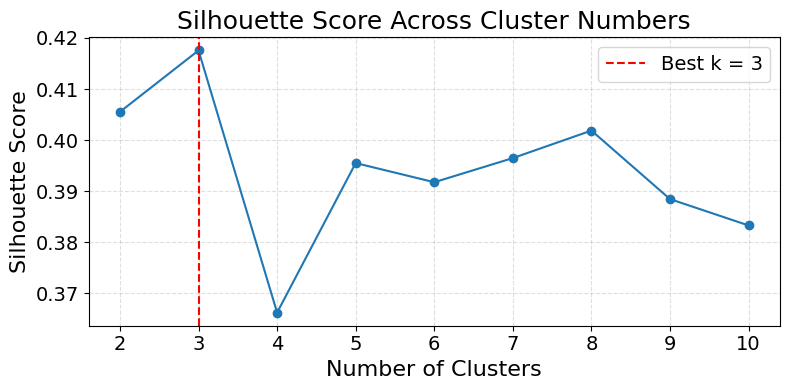

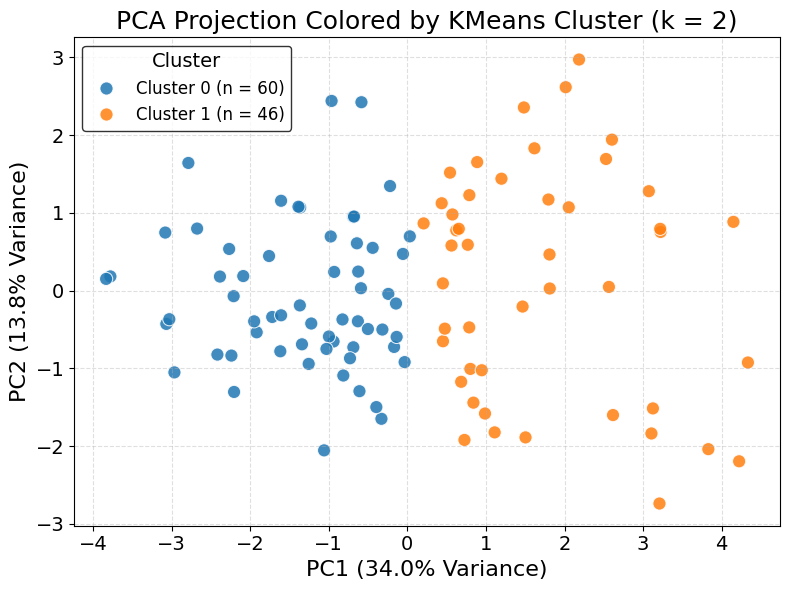

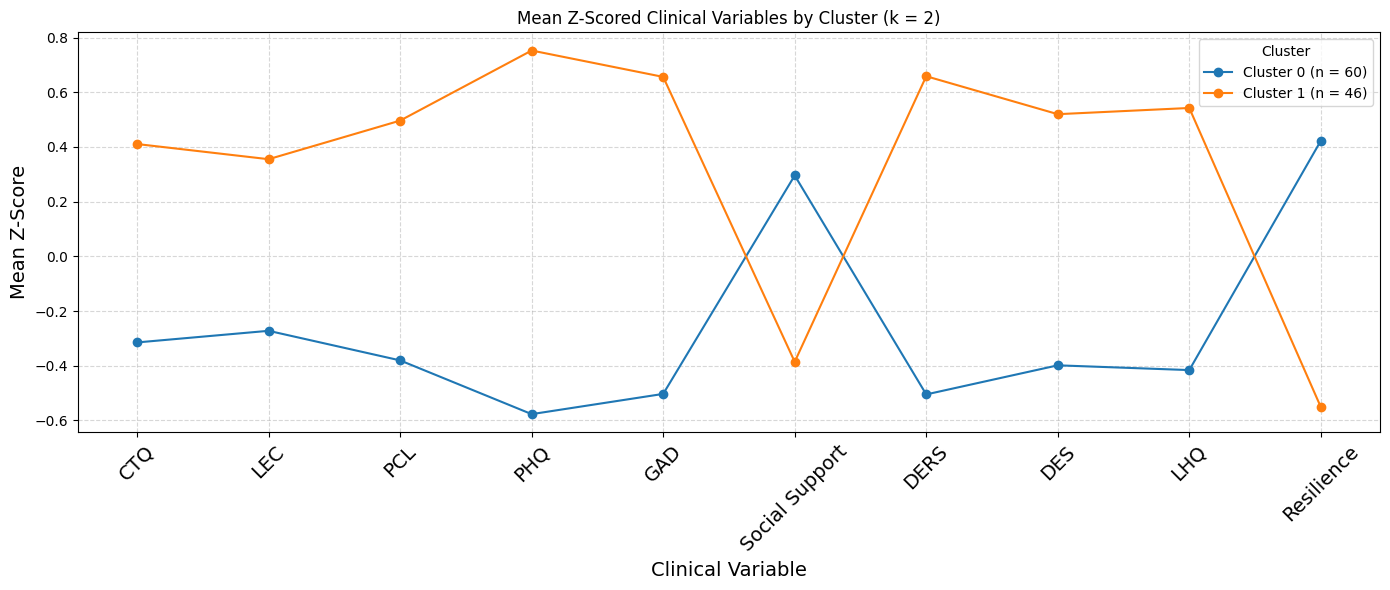

✅ Saved: only_Q_outputs\combined\subject_cluster_labels_k2.csv
Cluster
0    60
1    46
Name: count, dtype: int64


In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_csv(r"only_Q_outputs\combined\october_filtered_selected_columns_complete_subjects.csv")
rename_dict = {
    'b_ctq_total': 'CTQ',
    'b_lec_0_to_16_total': 'LEC',
    'b_pcl_total': 'PCL',
    'b_PHQ_total': 'PHQ',
    'b_GAD7_total': 'GAD',
    'b_social_support_total': 'Social Support',
    'b_DERS_total': 'DERS',
    'b_DES_average': 'DES',
    'b_LHQ_total': 'LHQ',
    'b_strength_average': 'Resilience'
}
# ============================================================
# 0. CONSISTENT CLUSTER COLOR PALETTE (for 2 clusters)
# ============================================================
cluster_palette = {
    0: "#1f77b4",   # blue
    1: "#ff7f0e",   # orange
}

# ============================================================
# 1. Clinical columns for PCA + KMeans
# ============================================================
measure_cols = [ 'b_ctq_total', 'b_lec_0_to_16_total',
'b_pcl_total', 'b_PHQ_total', 'b_GAD7_total', 'b_social_support_total',
'b_DERS_total', 'b_DES_average', 'b_LHQ_total','b_strength_average']
cols_for_filter = measure_cols + ["Subject_Code"]

df_pca = df[cols_for_filter].dropna()

pca_data_clinical = df_pca[measure_cols]
subject_codes = df_pca["Subject_Code"].astype(str)

scaled_data = pca_data_clinical.apply(zscore)

# ============================================================
# 2. PCA
# ============================================================
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
explained_var = pca.explained_variance_ratio_ * 100

pca_df = pd.DataFrame(
    principal_components,
    columns=['PC1', 'PC2'],
    index=pca_data_clinical.index
)

# ============================================================
# 3. KMEANS WITH FIXED k = 2
# ============================================================
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(principal_components)

# ============================================================
# 3b. REASSIGN CLUSTER LABELS SO CLUSTER WITH LOWEST PC1 = 0
# ============================================================
pca_df_temp = pd.DataFrame({
    'PC1': principal_components[:, 0],
    'Cluster': cluster_labels
})

cluster_pc1_means = pca_df_temp.groupby("Cluster")["PC1"].mean()
sorted_clusters = cluster_pc1_means.sort_values().index.tolist()
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters)}
print("Cluster relabeling mapping:", cluster_mapping)

cluster_labels_relab = np.array([cluster_mapping[c] for c in cluster_labels])
pca_df["Cluster"] = cluster_labels_relab

# ============================================================
# 4. Silhouette Score Plot (same as before: curve across k)
# ============================================================
range_n_clusters = list(range(2, 11))  # change 11 to whatever max-k you want
silhouette_scores = []

for kk in range_n_clusters:
    km = KMeans(n_clusters=kk, random_state=42, n_init=10)
    labels = km.fit_predict(principal_components)
    score = silhouette_score(principal_components, labels)
    silhouette_scores.append(score)

best_k = range_n_clusters[int(np.argmax(silhouette_scores))]

plt.figure(figsize=(8,4))
plt.plot(range_n_clusters, silhouette_scores, marker='o')

plt.axvline(best_k, color='red', linestyle='--',
            label=f"Best k = {best_k}")

plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Silhouette Score", fontsize=16)
plt.title("Silhouette Score Across Cluster Numbers", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

# ============================================================
# 5. PCA SCATTER WITH CONSISTENT COLORS (k=2)
# ============================================================
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette=cluster_palette,
    hue_order=[0, 1],
    s=90,
    alpha=0.85
)

plt.title("PCA Projection Colored by KMeans Cluster (k = 2)", fontsize=18)
plt.xlabel(f"PC1 ({explained_var[0]:.1f}% Variance)", fontsize=16)
plt.ylabel(f"PC2 ({explained_var[1]:.1f}% Variance)", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)

cluster_sizes = pca_df["Cluster"].value_counts().sort_index()
legend_labels = [f"Cluster {i} (n = {cluster_sizes[i]})" for i in [0, 1]]

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=legend_labels,
    title="Cluster",
    title_fontsize=14,
    fontsize=12,
    loc="upper left",
    frameon=True,
    facecolor="white",
    edgecolor="black"
)

plt.tight_layout()
plt.show()

# ============================================================
# 6. Z-SCORED CLUSTER MEANS ANALYSIS (k=2)
# ============================================================
clusters_z = pca_data_clinical.copy()
clusters_z = clusters_z.apply(zscore)
clusters_z["Cluster"] = cluster_labels_relab
clusters_z = clusters_z.dropna()

cluster_means_df = clusters_z.groupby("Cluster").mean().sort_index()
cluster_sizes = clusters_z["Cluster"].value_counts().sort_index()

# OPTIONAL: rename labels for plotting
rename_dict = {
    'b_ctq_total': 'CTQ',
    'b_lec_0_to_16_total': 'LEC',
    'b_pcl_total': 'PCL',
    'b_PHQ_total': 'PHQ',
    'b_GAD7_total': 'GAD',
    'b_social_support_total': 'Social Support',
    'b_DERS_total': 'DERS',
    'b_DES_average': 'DES',
    'b_LHQ_total': 'LHQ',
    'b_strength_average': 'Resilience'
}

cluster_means_df = cluster_means_df[measure_cols].rename(columns=rename_dict)

# ============================================================
# 7. FINAL PLOT: Mean Z-scored Clinical Profiles by Cluster (k=2)
# ============================================================
plt.figure(figsize=(14, 6))

for cluster_label, row in cluster_means_df.iterrows():
    color = cluster_palette.get(cluster_label)
    n = int(cluster_sizes.loc[cluster_label])
    plt.plot(
        cluster_means_df.columns,
        row.values,
        marker='o',
        label=f"Cluster {cluster_label} (n = {n})",
        color=color
    )

plt.title("Mean Z-Scored Clinical Variables by Cluster (k = 2)")
plt.xlabel("Clinical Variable", fontsize=14)
plt.ylabel("Mean Z-Score", fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# ============================================================
# 9. Save Subject_Code + Cluster labels to CSV
# ============================================================
cluster_out = pd.DataFrame({
    "Subject_Code": subject_codes.values,
    "Cluster": cluster_labels_relab
})

# (optional) sort by cluster then subject
cluster_out = cluster_out.sort_values(["Cluster", "Subject_Code"]).reset_index(drop=True)

out_path = r"only_Q_outputs\combined\subject_cluster_labels_k2.csv"
cluster_out.to_csv(out_path, index=False)

print("✅ Saved:", out_path)
print(cluster_out["Cluster"].value_counts().sort_index())


### doing k means for 3 clusters for the clinical data after pca using only the ottals from before pregnancy

Cluster relabeling mapping: {2: 0, 1: 1, 0: 2}


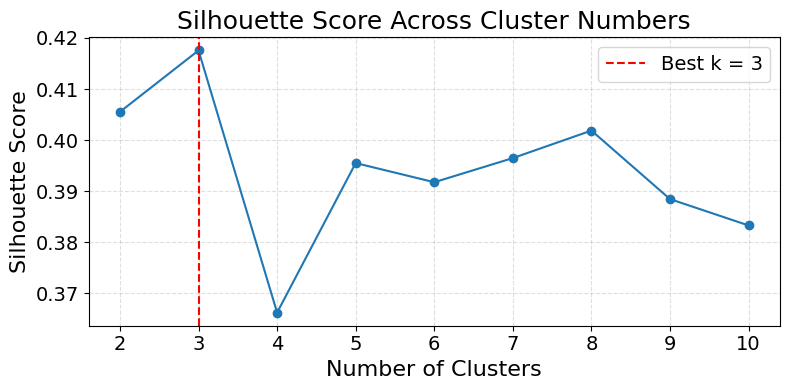

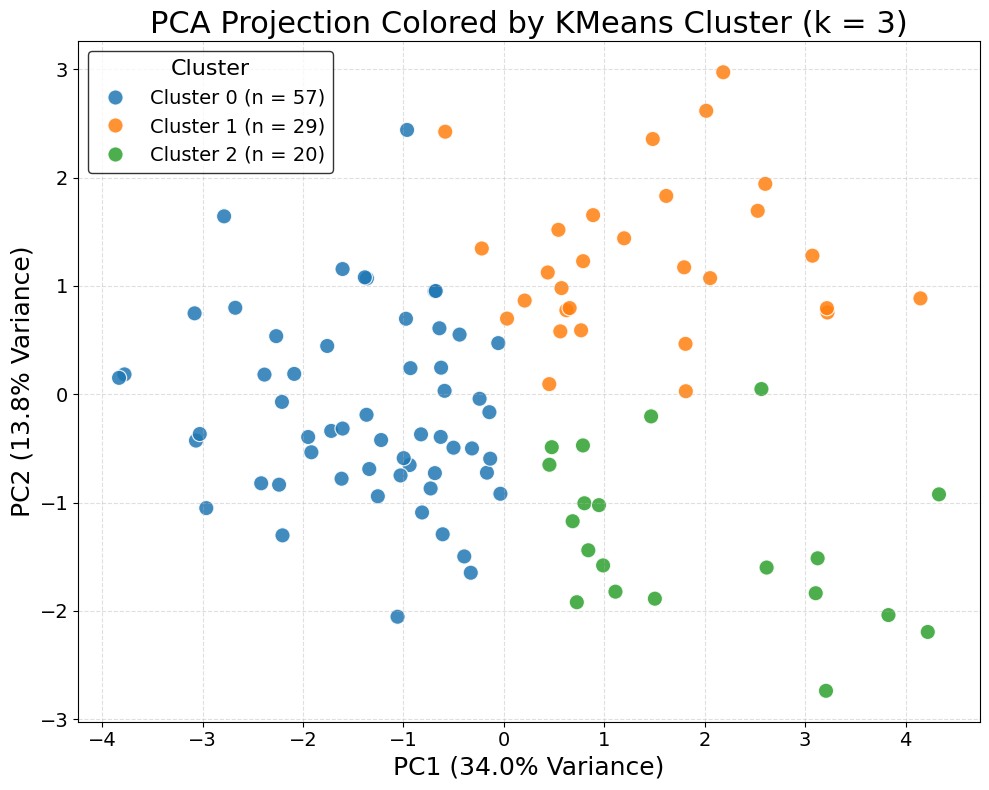

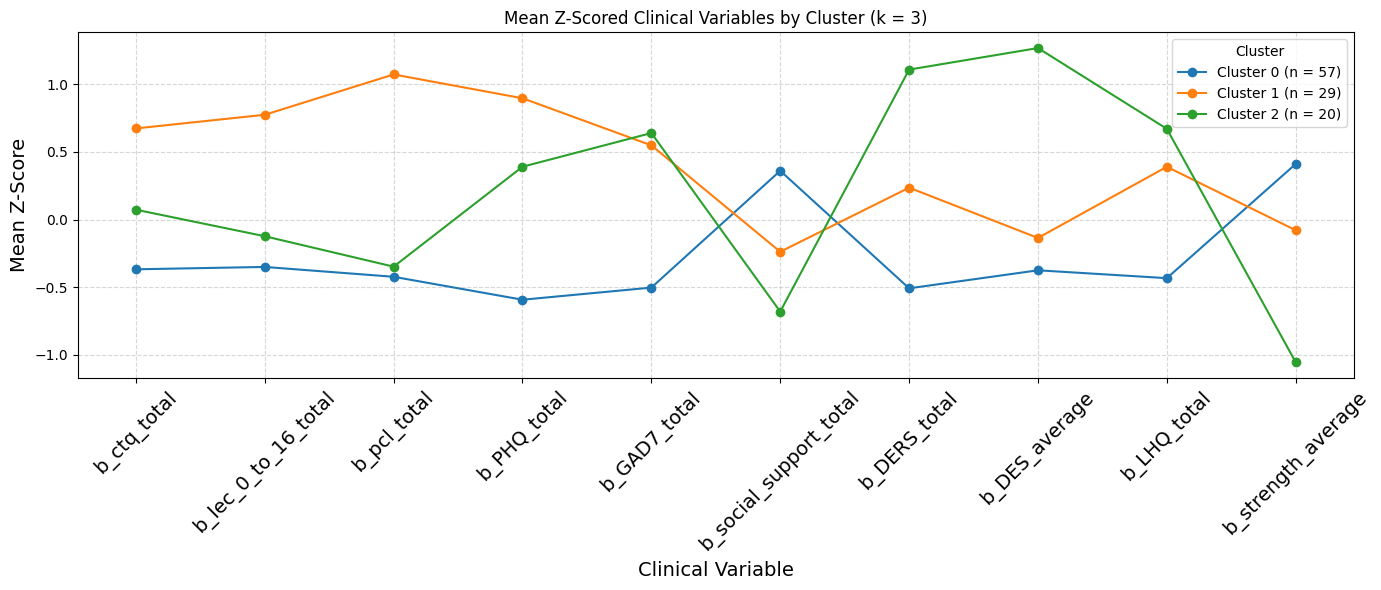

✅ Saved: only_Q_outputs\combined\subject_cluster_labels_k3.csv
Cluster
0    57
1    29
2    20
Name: count, dtype: int64


In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.cluster import KMeans
df = pd.read_csv(r"only_Q_outputs\combined\october_filtered_selected_columns_complete_subjects.csv")

# ============================================================
# 0. CONSISTENT CLUSTER COLOR PALETTE (for 3 clusters)
# ============================================================
cluster_palette = {
    0: "#1f77b4",   # blue
    1: "#ff7f0e",   # orange
    2: "#2ca02c",   # green
}

# ============================================================
# 1. Clinical columns for PCA + KMeans
# ============================================================
measure_cols = [ 'b_ctq_total', 'b_lec_0_to_16_total',
 'b_pcl_total', 'b_PHQ_total', 'b_GAD7_total', 'b_social_support_total',
'b_DERS_total', 'b_DES_average', 'b_LHQ_total','b_strength_average']

# Include Subject_Code in the selection used to drop rows with missing data
cols_for_filter = measure_cols + ["Subject_Code"]

# Keep only complete rows across clinical variables + Subject_Code
df_pca = df[cols_for_filter].dropna()

# Clinical data only (for PCA & clustering)
pca_data_clinical = df_pca[measure_cols]

# Subject codes aligned with pca_data_clinical
subject_codes = df_pca["Subject_Code"]

# Z-score normalization of clinical data (not Subject_Code)
scaled_data = pca_data_clinical.apply(zscore)

# ============================================================
# 2. PCA
# ============================================================
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
explained_var = pca.explained_variance_ratio_ * 100

pca_df = pd.DataFrame(
    principal_components,
    columns=['PC1', 'PC2'],
    index=pca_data_clinical.index
)

# ============================================================
# 3. KMEANS WITH FIXED k = 3
# ============================================================
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(principal_components)  # original labels (0,1,2 but arbitrary)

# ============================================================
# 3b. REASSIGN CLUSTER LABELS SO CLUSTER WITH LOWEST PC1 = 0
# ============================================================
pca_df_temp = pd.DataFrame({
    'PC1': principal_components[:, 0],
    'Cluster': cluster_labels
})

# Compute mean PC1 for each original cluster
cluster_pc1_means = pca_df_temp.groupby("Cluster")["PC1"].mean()

# Sort clusters by PC1 mean (negative → positive)
sorted_clusters = cluster_pc1_means.sort_values().index.tolist()

# Create new mapping {old_label: new_label}
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters)}
print("Cluster relabeling mapping:", cluster_mapping)

# Apply mapping to cluster_labels to get relabeled clusters
cluster_labels_relab = np.array([cluster_mapping[c] for c in cluster_labels])

# Add relabeled cluster labels to pca_df
pca_df["Cluster"] = cluster_labels_relab

# ============================================================
# 4. Silhouette Score Plot — with bigger fonts
# ============================================================
plt.figure(figsize=(8,4))
plt.plot(list(range_n_clusters), silhouette_scores, marker='o')

plt.axvline(best_k, color='red', linestyle='--',
            label=f"Best k = {best_k}")

plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Silhouette Score", fontsize=16)
plt.title("Silhouette Score Across Cluster Numbers", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()



# ============================================================
# PCA SCATTER WITH CONSISTENT COLORS + SUBJECT NUMBERS INSIDE PLOT
# ============================================================

plt.figure(figsize=(10, 8))

# Scatterplot
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette=cluster_palette,
    hue_order=[0, 1, 2],
    s=120,                     # bigger points
    alpha=0.85
)



# ------------------------------------------
# Build legend labels including cluster size
# ------------------------------------------
cluster_sizes = pca_df["Cluster"].value_counts().sort_index()
legend_labels = [f"Cluster {i} (n = {cluster_sizes[i]})" for i in [0, 1, 2]]

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=legend_labels,
    title="Cluster",
    title_fontsize=16,
    fontsize=14,
    loc="upper left",           # stays *inside* the plot
    frameon=True,
    facecolor="white",
    edgecolor="black"
)

# ------------------------------------------
# Labels & Formatting
# ------------------------------------------
plt.title("PCA Projection Colored by KMeans Cluster (k = 3)", fontsize=22)
plt.xlabel(f"PC1 ({explained_var[0]:.1f}% Variance)", fontsize=18)
plt.ylabel(f"PC2 ({explained_var[1]:.1f}% Variance)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


# ============================================================
# 5. Z-SCORED CLUSTER MEANS ANALYSIS
# ============================================================
# Build a dataframe with clinical variables + relabeled KMeans cluster
clusters_z = pca_data_clinical.copy()
clusters_z = clusters_z.apply(zscore)          # z-score clinical values
clusters_z["Cluster"] = cluster_labels_relab   # attach *relabelled* cluster labels
clusters_z = clusters_z.dropna()

# Compute cluster means, sorted so 0,1,2 (cluster 0 always "leftmost" on PC1)
cluster_means_df = clusters_z.groupby("Cluster").mean().sort_index()

# ============================================================
# 6. CLEAN COLUMN ORDERING + RENAMING
# ============================================================
desired_order =  [ "CTQ","LEC","PCL","PHQ","GAD","Social Support","DERS","DES","LHQ","Resilience"]

cluster_means_df = cluster_means_df[measure_cols]


# Count subjects per cluster (also sorted 0,1,2)
cluster_sizes = clusters_z["Cluster"].value_counts().sort_index()

# ============================================================
# 7. FINAL PLOT: Mean Z-scored Clinical Profiles by Cluster
# ============================================================
plt.figure(figsize=(14, 6))

for cluster_label, row in cluster_means_df.iterrows():
    color = cluster_palette.get(cluster_label)
    n = int(cluster_sizes.loc[cluster_label])
    plt.plot(
        cluster_means_df.columns,
        row.values,
        marker='o',
        label=f"Cluster {cluster_label} (n = {n})",
        color=color
    )

plt.title("Mean Z-Scored Clinical Variables by Cluster (k = 3)")
plt.xlabel("Clinical Variable",fontsize = 14)
plt.ylabel("Mean Z-Score",fontsize = 14)
plt.xticks(rotation=45,fontsize = 14)
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


 
    
    
# ============================================================
# SAVE Subject_Code + Cluster (k = 3)
# ============================================================
cluster_out = pd.DataFrame({
    "Subject_Code": subject_codes.astype(str).values,
    "Cluster": cluster_labels_relab
})

cluster_out = cluster_out.sort_values(["Cluster", "Subject_Code"]).reset_index(drop=True)

out_path = r"only_Q_outputs\combined\subject_cluster_labels_k3.csv"
cluster_out.to_csv(out_path, index=False)

print("✅ Saved:", out_path)
print(cluster_out["Cluster"].value_counts().sort_index())


### coloring the clusters form the kmeans (2 clusters) on the pca data of the depression and anxiaty

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =========================
# Paths
# =========================
pca_path = r"only_Q_outputs\combined\combined_pca_components.csv"
cluster_path = r"only_Q_outputs\combined\subject_cluster_labels_k2.csv"

# <-- separators file you created earlier
separators_path = r"only_Q_outputs\combined\timepoint_files\pc1_separators_by_timepoint.csv"
# If you saved it elsewhere, just update this path.

subject_col = "Subject_Code"
cluster_col = "Cluster"

# =========================
# Load data
# =========================
pca_df = pd.read_csv(pca_path)
cluster_df = pd.read_csv(cluster_path)

cluster_df = cluster_df[[subject_col, cluster_col]].drop_duplicates()

# =========================
# Merge clusters onto PCA
# =========================
df_plot = pca_df.merge(cluster_df, on=subject_col, how="left")

# =========================
# Load separators
# =========================
sep_df = pd.read_csv(separators_path)  # columns: timepoint, PC1_separator

# optional: order timepoints if you want consistent labeling
timepoint_order = ["b", "t1", "t2", "t3", "after"]
if "timepoint" in sep_df.columns:
    sep_df["timepoint"] = pd.Categorical(sep_df["timepoint"], categories=timepoint_order, ordered=True)
    sep_df = sep_df.sort_values("timepoint")

# =========================
# Plot
# =========================
plt.figure(figsize=(7, 5))

# masks
mask_c0 = df_plot[cluster_col].astype("float").eq(0)
mask_c1 = df_plot[cluster_col].astype("float").eq(1)
mask_other_cluster = df_plot[cluster_col].notna() & ~(mask_c0 | mask_c1)
mask_no_cluster = df_plot[cluster_col].isna()

# Cluster 0 (blue)
plt.scatter(
    df_plot.loc[mask_c0, "PC1"],
    df_plot.loc[mask_c0, "PC2"],
    color="tab:blue",
    alpha=0.8,
    s=40,
    label="Cluster 0"
)

# Cluster 1 (orange)
plt.scatter(
    df_plot.loc[mask_c1, "PC1"],
    df_plot.loc[mask_c1, "PC2"],
    color="tab:orange",
    alpha=0.8,
    s=40,
    label="Cluster 1"
)



# No cluster (grey)
if mask_no_cluster.any():
    plt.scatter(
        df_plot.loc[mask_no_cluster, "PC1"],
        df_plot.loc[mask_no_cluster, "PC2"],
        color="lightgray",
        alpha=0.6,
        s=35,
        label="No cluster"
    )

# =========================
# Add separators (vertical lines)
# =========================
y_min, y_max = plt.ylim()

for _, row in sep_df.iterrows():
    tp = str(row["timepoint"])
    x = float(row["PC1_separator"])

    plt.axvline(x, linestyle="--", linewidth=2, color="black", alpha=0.8)
    plt.text(
        x, y_max,
        f"{tp}: {x:.3f}",
        rotation=90,
        va="top",
        ha="right",
        fontsize=8
    )

# labels/title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (PC1 vs PC2) — Cluster 0/1 + separators")
plt.grid(alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# =========================
# Sanity check
# =========================
print("Cluster counts (including NaN):")
print(df_plot[cluster_col].value_counts(dropna=False))


FileNotFoundError: [Errno 2] No such file or directory: 'only_Q_outputs\\combined\\timepoint_files\\pc1_separators_by_timepoint.csv'

### coloring the clusters form the kmeans (2 clusters) on the pca data of the depression and anxiaty

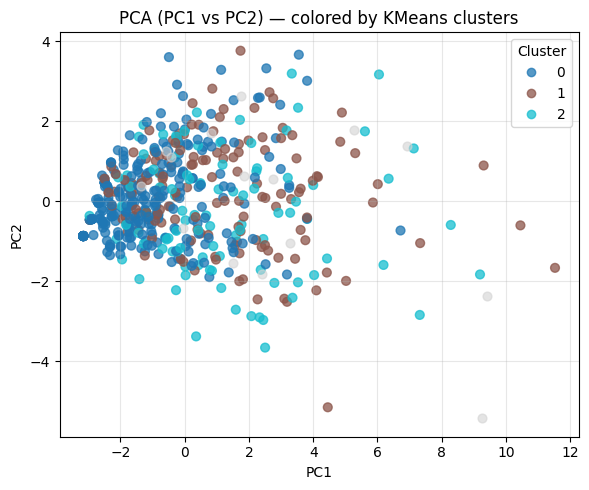

Cluster counts (including NaN):
Cluster
0.0    285
1.0    145
2.0    100
NaN     15
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =========================
# Paths
# =========================
pca_path = r"only_Q_outputs\combined\combined_pca_components.csv"
cluster_path = r"only_Q_outputs\combined\subject_cluster_labels_k3.csv"

subject_col = "Subject_Code"
cluster_col = "Cluster"

# =========================
# Load data
# =========================
pca_df = pd.read_csv(pca_path)
cluster_df = pd.read_csv(cluster_path)

# keep only subject + cluster
cluster_df = cluster_df[[subject_col, cluster_col]].drop_duplicates()

# =========================
# Merge clusters onto PCA
# =========================
df_plot = pca_df.merge(
    cluster_df,
    on=subject_col,
    how="left"   # <-- keep all PCA subjects
)

# =========================
# Plot
# =========================
plt.figure(figsize=(6, 5))

# subjects WITH cluster
mask_cluster = df_plot[cluster_col].notna()
mask_no_cluster = ~mask_cluster

# plot clustered subjects
sc = plt.scatter(
    df_plot.loc[mask_cluster, "PC1"],
    df_plot.loc[mask_cluster, "PC2"],
    c=df_plot.loc[mask_cluster, cluster_col].astype(int),
    cmap="tab10",
    alpha=0.75,
    s=40
)

# plot subjects WITHOUT cluster (grey)
plt.scatter(
    df_plot.loc[mask_no_cluster, "PC1"],
    df_plot.loc[mask_no_cluster, "PC2"],
    color="lightgray",
    alpha=0.6,
    s=40,
    label="No cluster"
)

# labels
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (PC1 vs PC2) — colored by KMeans clusters")

# legend for clusters
plt.legend(
    *sc.legend_elements(),
    title="Cluster",
    loc="best"
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =========================
# Sanity check
# =========================
print("Cluster counts (including NaN):")
print(df_plot[cluster_col].value_counts(dropna=False))


### creating regression parmeters file with the totals of the depression and anxiety during th pregnancy

In [ ]:
import pandas as pd
import os

# ----------------------------
# 1) Build valid_subjects
# ----------------------------
presence_df = pd.read_csv(r'only_Q_outputs/5_timepoints/subject_timepoint_presence.csv')

timepoint_cols = ['b', 't1', 't2', 't3', 'after']
valid_subjects = presence_df.loc[
    presence_df[timepoint_cols].eq(1).all(axis=1),
    'Subject_Code'
].astype(str)

valid_subjects_set = set(valid_subjects)

# ----------------------------
# 2) Read your Excel file (all sheets)
# ----------------------------
excel_path = r"data\original_Q_data\Study_Questionnaire_Responses_October.xlsx"
\
# Read all sheets into a dict: {sheet_name: df}
sheets = pd.read_excel(excel_path, sheet_name=None)

print("Sheets found:", list(sheets.keys()))

# ----------------------------
# 3) Choose columns you want
# ----------------------------
specified_columns = [ 'b_PHQ_total','T1_PHQ_total','T2_PHQ_total','T3_PHQ_total','after_PHQ_total',
'b_GAD7_total','T1_GAD7_total','T2_GAD7_total','T3_GAD7_total','after_GAD7_total']


keep_cols = ["Subject_Code"] + specified_columns

# ----------------------------
# 4) Filter + collect into ONE dataframe
# ----------------------------
all_parts = []

for sheet_name, df in sheets.items():
    if "Subject_Code" not in df.columns:
        print(f"Skipping sheet '{sheet_name}' (no Subject_Code column)")
        continue

    df = df.copy()
    df["Subject_Code"] = df["Subject_Code"].astype(str)

    # keep only valid subjects
    df = df[df["Subject_Code"].isin(valid_subjects_set)].copy()

    # keep only columns that exist in this sheet
    cols_in_sheet = [c for c in keep_cols if c in df.columns]
    missing_here = [c for c in keep_cols if c not in df.columns]
    if missing_here:
        print(f"Sheet '{sheet_name}' missing columns: {missing_here}")

    df = df[cols_in_sheet].copy()

    # add timepoint/sheet label (optional but useful)

    all_parts.append(df)

if not all_parts:
    raise ValueError("No sheets contained Subject_Code (or nothing left after filtering).")

final_df = pd.concat(all_parts, ignore_index=True)

print("✅ Final rows:", len(final_df))
print("✅ Unique subjects:", final_df["Subject_Code"].nunique())

# ----------------------------
# 5) Save ONE CSV
# ----------------------------
out_dir = "only_Q_outputs/combined"
os.makedirs(out_dir, exist_ok=True)

final_df.to_csv( "only_Q_outputs/combined/phq_gad7_totals.csv", index=False)

print("📄 Saved:", "only_Q_outputs/combined/phq_gad7_totals.csv")


Sheets found: ['Sheet1']
✅ Final rows: 109
✅ Unique subjects: 109
📄 Saved: only_Q_outputs/combined/phq_gad7_totals.csv


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# =========================
# Paths
# =========================
pca_path        = r"only_Q_outputs\combined\combined_pca_components.csv"
separators_path = r"only_Q_outputs\combined\timepoint_files\pc1_separators_by_timepoint.csv"
cluster_path    = r"only_Q_outputs\combined\subject_cluster_labels_k2.csv"
out_path        = r"only_Q_outputs\combined\subject_all_timepoints_pc1_3class_with_cluster.csv"

subject_col = "Subject_Code"
cluster_col = "Cluster"
timepoint_order = ["b", "t1", "t2", "t3", "after"]

# =========================
# Load
# =========================
pca_df = pd.read_csv(pca_path)
sep_df = pd.read_csv(separators_path)      # columns: timepoint, PC1_separator
cluster_df = pd.read_csv(cluster_path)     # columns include Subject_Code, Cluster

# Ensure timepoint column exists
if "timepoint" not in pca_df.columns:
    for alt in ["Timepoint", "TP", "tp"]:
        if alt in pca_df.columns:
            pca_df = pca_df.rename(columns={alt: "timepoint"})
            break
    else:
        raise ValueError("PCA file must contain a 'timepoint' column (or rename it to 'timepoint').")

# Clean keys
pca_df[subject_col] = pca_df[subject_col].astype(str).str.strip()
pca_df["timepoint"] = pca_df["timepoint"].astype(str).str.strip()

sep_df["timepoint"] = sep_df["timepoint"].astype(str).str.strip()

cluster_df[subject_col] = cluster_df[subject_col].astype(str).str.strip()
cluster_df = cluster_df[[subject_col, cluster_col]].drop_duplicates(subset=[subject_col])

# =========================
# Get thresholds for b and t1 (GLOBAL cutoffs)
# =========================
sep_map = sep_df.set_index("timepoint")["PC1_separator"].to_dict()

if "b" not in sep_map or "t1" not in sep_map:
    raise ValueError(f"Separators file must include both 'b' and 't1'. Found: {sorted(sep_map.keys())}")

b_thr = float(sep_map["b"])
t1_thr = float(sep_map["t1"])

low_thr, high_thr = sorted([b_thr, t1_thr])
print(f"Using global cutoffs: low=b({b_thr:.6f}), high=t1({t1_thr:.6f})")

# =========================
# Keep only expected timepoints (optional but recommended)
# =========================
pca_df = pca_df[pca_df["timepoint"].isin(timepoint_order)].copy()

# If duplicates per subject+timepoint exist, keep max PC1 (or change rule)
pca_df = (
    pca_df.sort_values("PC1")
          .drop_duplicates(subset=[subject_col, "timepoint"], keep="last")
)

# =========================
# 3-class encoding for EVERY timepoint row
# 0: below low_thr
# 2: between thresholds (inclusive)
# 1: above high_thr
# =========================
pca_df["tp_class"] = np.select(
    [
        pca_df["PC1"] < low_thr,
        pca_df["PC1"] > high_thr
    ],
    [
        0,
        1
    ],
    default=2
).astype(int)

# =========================
# Pivot wide: one row per subject, one column per timepoint
# =========================
wide = (
    pca_df.pivot_table(
        index=subject_col,
        columns="timepoint",
        values="tp_class",
        aggfunc="max"  # if duplicates slipped through, keep "highest" class
    )
    .reset_index()
)

# Order columns nicely
ordered_cols = [subject_col] + [tp for tp in timepoint_order if tp in wide.columns]
wide = wide[ordered_cols]

# =========================
# Merge KMeans cluster label
# =========================
wide = wide.merge(cluster_df, on=subject_col, how="left")

# Put Cluster right after Subject_Code
cols = [subject_col, cluster_col] + [c for c in wide.columns if c not in [subject_col, cluster_col]]
wide = wide[cols]

# =========================
# Save
# =========================
Path(out_path).parent.mkdir(parents=True, exist_ok=True)
wide.to_csv(out_path, index=False)

print("✅ Saved:", out_path)
print(wide.head())

# Optional quick counts per timepoint
for tp in [tp for tp in timepoint_order if tp in wide.columns]:
    print(f"\nCounts for {tp}:")
    print(wide[tp].value_counts(dropna=False).sort_index())


Using global cutoffs: low=b(-0.116535), high=t1(1.512484)
✅ Saved: only_Q_outputs\combined\subject_all_timepoints_pc1_3class_with_cluster.csv
  Subject_Code  Cluster  b  t1  t2  t3  after
0        CT003      0.0  2   0   2   2      0
1        CT004      1.0  0   0   0   0      1
2        CT005      1.0  2   1   2   1      0
3        CT007      1.0  1   1   1   1      1
4        CT008      1.0  1   0   2   0      0

Counts for b:
b
0    68
1    22
2    19
Name: count, dtype: int64

Counts for t1:
t1
0    51
1    29
2    29
Name: count, dtype: int64

Counts for t2:
t2
0    60
1    27
2    22
Name: count, dtype: int64

Counts for t3:
t3
0    66
1    27
2    16
Name: count, dtype: int64

Counts for after:
after
0    66
1    24
2    19
Name: count, dtype: int64


In [ ]:
import pandas as pd
from pathlib import Path

# =========================
# Paths
# =========================
binary_path = r"only_Q_outputs\combined\subject_all_timepoints_pc1_3class_with_cluster.csv"
pca_path    = r"only_Q_outputs\combined\combined_pca_components.csv"

out_healthy = r"only_Q_outputs\combined\start_healthy_subjects_pca.csv"
out_clin    = r"only_Q_outputs\combined\start_clinincal_subjects_pca.csv"

subject_col = "Subject_Code"

# =========================
# Load files
# =========================
bin_df = pd.read_csv(binary_path)
pca_df = pd.read_csv(pca_path)

# Clean Subject_Code
bin_df[subject_col] = bin_df[subject_col].astype(str).str.strip()
pca_df[subject_col] = pca_df[subject_col].astype(str).str.strip()

# Make sure needed columns are numeric
bin_df["Cluster"] = pd.to_numeric(bin_df["Cluster"], errors="coerce")
# =========================
# Select subject sets (SAME condition for both)
# =========================
selected_subjects_clinical  = set(
    bin_df.loc[(bin_df["Cluster"] == 1) & (bin_df["b"] == 1) & (bin_df["t1"] == 1) & (bin_df["t2"] == 1) & (bin_df["t3"] == 1) & (bin_df["after"] == 1), subject_col]
)
selected_subjects_healthy  = set(
    bin_df.loc[(bin_df["Cluster"] == 0) & (bin_df["b"] == 0)& (bin_df["t1"] == 0)& (bin_df["t2"] == 0)& (bin_df["t3"] == 0)& (bin_df["after"] == 0), subject_col]
)
healthy_subjects = selected_subjects_healthy
clinical_subjects = selected_subjects_clinical

print("Selected subjects (Cluster=1 & b=1):", len(selected_subjects_clinical))
print("Selected subjects (Cluster=0 & b=0):", len(selected_subjects_healthy))



# =========================
# Filter PCA rows for those subjects (all timepoints)
# =========================
healthy_pca = pca_df[pca_df[subject_col].isin(healthy_subjects)].copy()
clinical_pca = pca_df[pca_df[subject_col].isin(clinical_subjects)].copy()

# =========================
# Save
# =========================
Path(out_healthy).parent.mkdir(parents=True, exist_ok=True)

healthy_pca.to_csv(out_healthy, index=False)
clinical_pca.to_csv(out_clin, index=False)

print("✅ Saved:", out_healthy, "| rows:", len(healthy_pca))
print("✅ Saved:", out_clin, "| rows:", len(clinical_pca))


Selected subjects (Cluster=1 & b=1): 4
Selected subjects (Cluster=0 & b=0): 22
✅ Saved: only_Q_outputs\combined\start_healthy_subjects_pca.csv | rows: 110
✅ Saved: only_Q_outputs\combined\start_clinincal_subjects_pca.csv | rows: 20


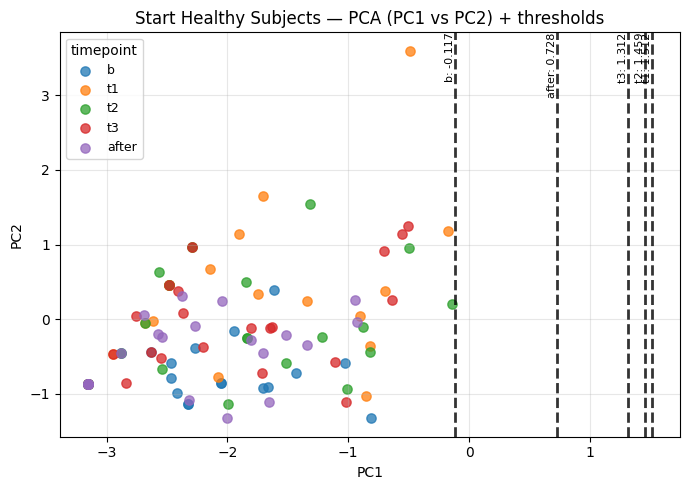

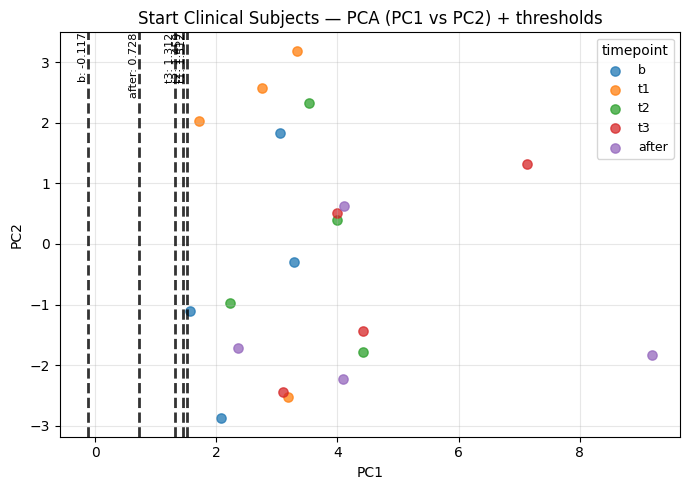

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Paths
# =========================
healthy_path   = r"only_Q_outputs\combined\start_healthy_subjects_pca.csv"
clinical_path  = r"only_Q_outputs\combined\start_clinincal_subjects_pca.csv"
separators_path = r"only_Q_outputs\combined\timepoint_files\pc1_separators_by_timepoint.csv"

# If your columns differ, update these:
pc1_col = "PC1"
pc2_col = "PC2"
tp_col  = "timepoint"

timepoint_order = ["b", "t1", "t2", "t3", "after"]

# =========================
# Load
# =========================
healthy_df = pd.read_csv(healthy_path)
clinical_df = pd.read_csv(clinical_path)
sep_df = pd.read_csv(separators_path)   # columns: timepoint, PC1_separator

# Clean timepoint ordering (optional)
if tp_col in sep_df.columns:
    sep_df[tp_col] = sep_df[tp_col].astype(str).str.strip()
    sep_df[tp_col] = pd.Categorical(sep_df[tp_col], categories=timepoint_order, ordered=True)
    sep_df = sep_df.sort_values(tp_col)

def plot_group(df, title):
    df = df.copy()

    # Ensure timepoint exists + clean it
    if tp_col in df.columns:
        df[tp_col] = df[tp_col].astype(str).str.strip()
        df[tp_col] = pd.Categorical(df[tp_col], categories=timepoint_order, ordered=True)

    plt.figure(figsize=(7, 5))

    # ---- Scatter ----
    if tp_col in df.columns:
        # color by timepoint
        for tp in timepoint_order:
            sub = df[df[tp_col] == tp]
            if len(sub) == 0:
                continue
            plt.scatter(sub[pc1_col], sub[pc2_col], s=45, alpha=0.75, label=str(tp))
        plt.legend(title="timepoint", loc="best", fontsize=9)
    else:
        # single color
        plt.scatter(df[pc1_col], df[pc2_col], s=45, alpha=0.75)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.grid(alpha=0.3)

    # ---- Add thresholds (vertical lines) ----
    y_min, y_max = plt.ylim()

    for _, row in sep_df.iterrows():
        tp = str(row[tp_col])
        x = float(row["PC1_separator"])

        plt.axvline(x, linestyle="--", linewidth=2, color="black", alpha=0.8)
        plt.text(
            x, y_max,
            f"{tp}: {x:.3f}",
            rotation=90,
            va="top",
            ha="right",
            fontsize=8
        )

    plt.tight_layout()
    plt.show()

# =========================
# Plot both groups
# =========================
plot_group(healthy_df, "Start Healthy Subjects — PCA (PC1 vs PC2) + thresholds")
plot_group(clinical_df, "Start Clinical Subjects — PCA (PC1 vs PC2) + thresholds")


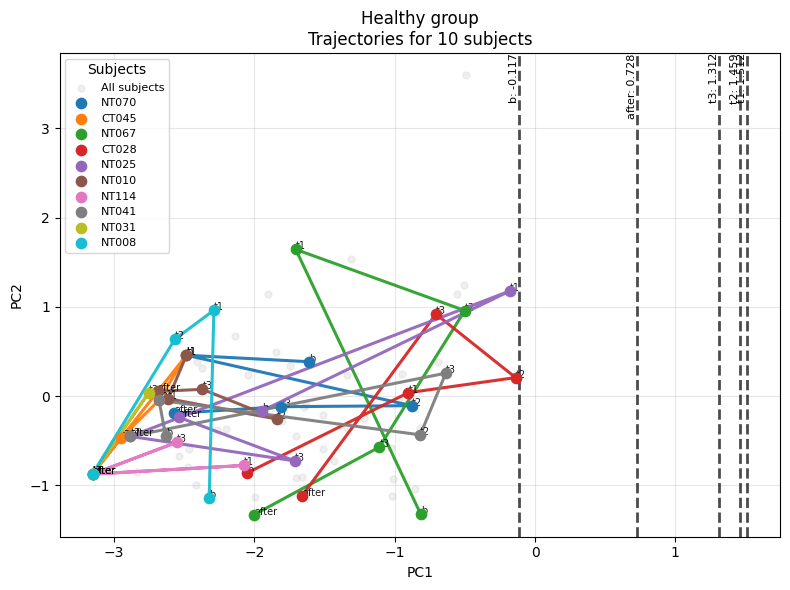

Healthy group: plotted subjects:
['NT070', 'CT045', 'NT067', 'CT028', 'NT025', 'NT010', 'NT114', 'NT041', 'NT031', 'NT008']


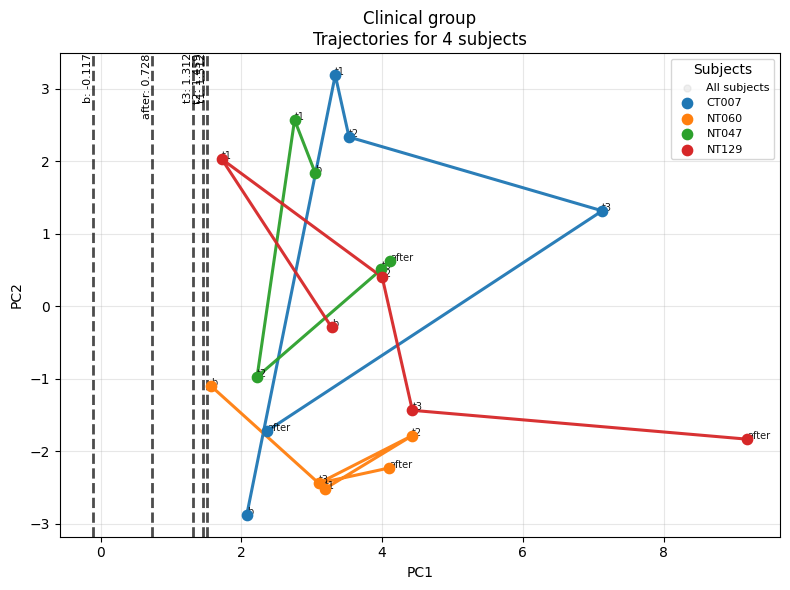

Clinical group: plotted subjects:
['CT007', 'NT060', 'NT047', 'NT129']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# =========================
# Paths
# =========================
healthy_path    = r"only_Q_outputs\combined\start_healthy_subjects_pca.csv"
clinical_path   = r"only_Q_outputs\combined\start_clinincal_subjects_pca.csv"
separators_path = r"only_Q_outputs\combined\timepoint_files\pc1_separators_by_timepoint.csv"

subject_col = "Subject_Code"
pc1_col = "PC1"
pc2_col = "PC2"
tp_col  = "timepoint"
timepoint_order = ["b", "t1", "t2", "t3", "after"]

# pick 10 subjects per file
N_SUBJECTS = 10
RANDOM_SEED = 0  # change for different samples (or set None)

# =========================
# Load
# =========================
healthy_df  = pd.read_csv(healthy_path)
clinical_df = pd.read_csv(clinical_path)
sep_df      = pd.read_csv(separators_path)  # columns: timepoint, PC1_separator

# Clean separators order
sep_df[tp_col] = sep_df[tp_col].astype(str).str.strip()
sep_df[tp_col] = pd.Categorical(sep_df[tp_col], categories=timepoint_order, ordered=True)
sep_df = sep_df.sort_values(tp_col)

def plot_group_with_trajectories(df, title):
    df = df.copy()

    # clean
    df[subject_col] = df[subject_col].astype(str).str.strip()
    df[tp_col] = df[tp_col].astype(str).str.strip()
    df[tp_col] = pd.Categorical(df[tp_col], categories=timepoint_order, ordered=True)

    # choose 10 subjects
    subjects = df[subject_col].dropna().unique()
    if len(subjects) == 0:
        print(f"No subjects found for {title}")
        return

    rng = np.random.default_rng(RANDOM_SEED) if RANDOM_SEED is not None else np.random.default_rng()
    chosen = subjects if len(subjects) <= N_SUBJECTS else rng.choice(subjects, size=N_SUBJECTS, replace=False)

    # assign colors
    colors = {subj: cm.tab10(i % 10) for i, subj in enumerate(chosen)}

    plt.figure(figsize=(8, 6))

    # ---- background scatter (all points) ----
    plt.scatter(df[pc1_col], df[pc2_col], color="lightgray", alpha=0.35, s=25, label="All subjects")

    # ---- thresholds ----
    y_min, y_max = plt.ylim()
    for _, row in sep_df.iterrows():
        tp = str(row[tp_col])
        x = float(row["PC1_separator"])
        plt.axvline(x, linestyle="--", linewidth=2, color="black", alpha=0.7)
        plt.text(x, y_max, f"{tp}: {x:.3f}", rotation=90, va="top", ha="right", fontsize=8)

    # ---- trajectories for chosen subjects ----
    for subj in chosen:
        dsub = df[df[subject_col] == subj].copy().sort_values(tp_col)

        # keep only valid timepoints and drop missing PC values
        dsub = dsub[dsub[tp_col].isin(timepoint_order)].dropna(subset=[pc1_col, pc2_col])

        if len(dsub) < 2:
            continue

        c = colors[subj]

        # line
        plt.plot(dsub[pc1_col], dsub[pc2_col], linewidth=2.2, alpha=0.95, color=c, zorder=3)

        # points
        plt.scatter(dsub[pc1_col], dsub[pc2_col], s=55, color=c, zorder=4, label=f"{subj}")

        # optional: annotate each point by timepoint
        for _, r in dsub.iterrows():
            plt.text(r[pc1_col], r[pc2_col], str(r[tp_col]), fontsize=7, alpha=0.9)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{title}\nTrajectories for {min(N_SUBJECTS, len(subjects))} subjects")
    plt.grid(alpha=0.3)

    # keep legend readable (many labels): show only chosen subjects + "All subjects"
    plt.legend(loc="best", fontsize=8, title="Subjects", ncol=1)
    plt.tight_layout()
    plt.show()

    print(f"{title}: plotted subjects:")
    print(list(chosen))

# =========================
# Plot both groups
# =========================
plot_group_with_trajectories(healthy_df,  "Healthy group")
plot_group_with_trajectories(clinical_df, "Clinical group")


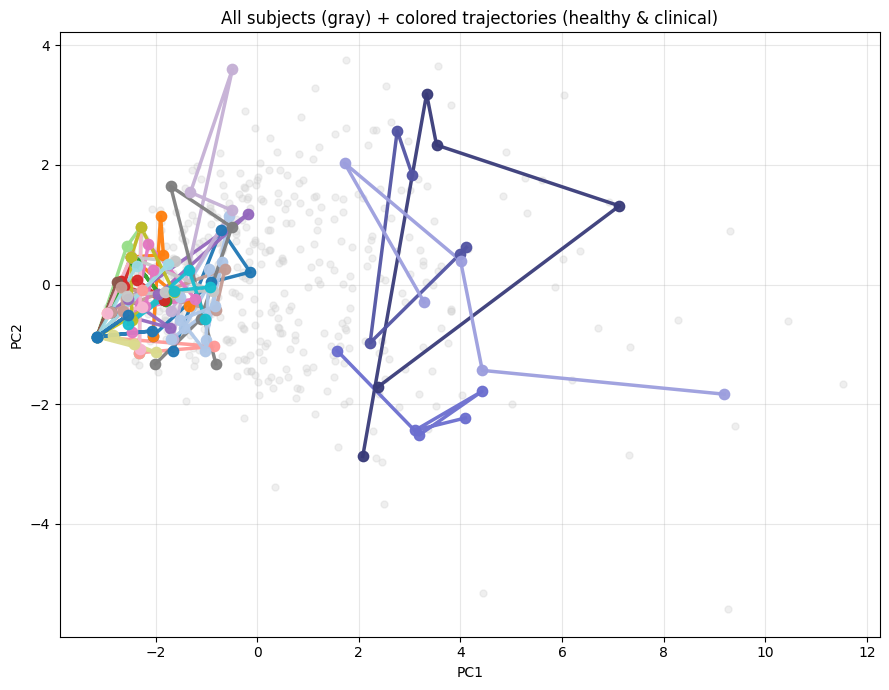

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Paths
# =========================
pca_path      = r"only_Q_outputs\combined\combined_pca_components.csv"
healthy_path  = r"only_Q_outputs\combined\start_healthy_subjects_pca.csv"
clinical_path = r"only_Q_outputs\combined\start_clinincal_subjects_pca.csv"

# Columns
subject_col = "Subject_Code"
tp_col = "timepoint"
pc1_col = "PC1"
pc2_col = "PC2"
timepoint_order = ["b", "t1", "t2", "t3", "after"]

# =========================
# Load
# =========================
pca_df = pd.read_csv(pca_path)
healthy_df = pd.read_csv(healthy_path)
clinical_df = pd.read_csv(clinical_path)

# Clean keys
for df in (pca_df, healthy_df, clinical_df):
    df[subject_col] = df[subject_col].astype(str).str.strip()
pca_df[tp_col] = pca_df[tp_col].astype(str).str.strip()

# Subjects to highlight
healthy_subjects  = sorted(set(healthy_df[subject_col].dropna().unique()))
clinical_subjects = sorted(set(clinical_df[subject_col].dropna().unique()))
highlight_subjects = set(healthy_subjects) | set(clinical_subjects)

# Keep only expected timepoints + order them
pca_df = pca_df[pca_df[tp_col].isin(timepoint_order)].copy()
pca_df[tp_col] = pd.Categorical(pca_df[tp_col], categories=timepoint_order, ordered=True)

# If duplicates per subject+timepoint exist, keep last (or change rule)
pca_df = (pca_df.sort_values([subject_col, tp_col])
                .drop_duplicates(subset=[subject_col, tp_col], keep="last"))

# =========================
# Color maps: distinct colors per trajectory
# =========================
cmap_h = plt.get_cmap("tab20")   # 20 distinct
cmap_c = plt.get_cmap("tab20b")  # another 20
cmap_c2 = plt.get_cmap("tab20c") # another 20

healthy_colors = {s: cmap_h(i % cmap_h.N) for i, s in enumerate(healthy_subjects)}
clinical_colors = {}
for i, s in enumerate(clinical_subjects):
    clinical_colors[s] = cmap_c(i) if i < cmap_c.N else cmap_c2((i - cmap_c.N) % cmap_c2.N)

# =========================
# Plot
# =========================
plt.figure(figsize=(9, 7))

# --- Background: ALL points in gray ---
plt.scatter(
    pca_df[pc1_col], pca_df[pc2_col],
    color="lightgray", alpha=0.35, s=25, zorder=1
)

# Grid in the background
plt.grid(alpha=0.3)

def plot_trajectories(subject_list, color_map):
    for subj in subject_list:
        dsub = pca_df[pca_df[subject_col] == subj].copy().sort_values(tp_col)
        dsub = dsub.dropna(subset=[pc1_col, pc2_col])
        if len(dsub) < 2:
            continue


        c = color_map[subj]
        # line
        plt.plot(
            dsub[pc1_col], dsub[pc2_col],
            color=c, linewidth=2.5, alpha=0.95, zorder=3
        )
        # points
        plt.scatter(
            dsub[pc1_col], dsub[pc2_col],
            color=c, s=55, alpha=0.95, zorder=4
        )

# --- Overlay trajectories (each subject different color) ---
plot_trajectories(healthy_subjects, healthy_colors)
plot_trajectories(clinical_subjects, clinical_colors)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("All subjects (gray) + colored trajectories (healthy & clinical)")
plt.tight_layout()
plt.show()
